# Projet Calibration

### Théo MIDAVAINE & Matthieu JULIEN

In [7]:
import math
import pandas as pd
import numpy as np
import random 
import copy

from scipy.stats import norm

import matplotlib.pyplot as plt

### I – Densités risque neutre 

1/ Sur les prix d’option données dans le tableau ci-après, calibrer une densité risque neutre en utilisant 
la formule de Breeden-Litzenberger et la technique de Shimko. Comparer avec une densité gaussienne. 

In [8]:
data = pd.DataFrame()
data["strikes"] = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
data["prices"] = [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]

In [9]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


def newton_raphson_implied_vol(row, S, r, initial_guess=0.2, T=1):     
    sigma = initial_guess     
    K = row['strikes']
    price_market = row['prices']  
    for _ in range(100):           
        d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price_model = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)  
        vega = S * np.sqrt(T) * norm.pdf(d1)  
        price_diff = price_market - price_model  
        
        if np.abs(price_diff) < 1e-8:               
            return sigma                  
        sigma += price_diff / vega  # Mise à jour de sigma
        
        if sigma < 0:               
            sigma = 0.001     
    return sigma

def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []
    for x in x_interpolated:
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

Nelder-Mead function used as minimizing function that will be used throughout the project

In [10]:
def nelder_mead(f, x_start, *args,
                step=0.1, no_improve_thr=10e-2,
                no_improv_break=10, max_iter=0,
                alpha=1., gamma=2., rho=-0.5, sigma=0.5):
    # init
    dim = len(x_start)
    prev_best = f(x_start,len(x_start),args)
    no_improv = 0
    res = [[x_start, prev_best]]

    for i in range(dim):
        x = copy.copy(x_start)
        x[i] = x[i] + step
        score = f(x,len(x),args)
        res.append([x, score])

    # simplex iter
    iters = 0
    while 1:
        # order
        res.sort(key=lambda x: x[1])
        best = res[0][1]

        # break after max_iter
        if max_iter and iters >= max_iter:
            return res[0]
        iters += 1

        # break after no_improv_break iterations with no improvement
        #print('error:', best)

        if best < prev_best - no_improve_thr:
            no_improv = 0
            prev_best = best
        else:
            no_improv += 1

        if no_improv >= no_improv_break:
            return res[0]

        # centroid
        x0 = [0.] * dim
        for tup in res[:-1]:
            for i, c in enumerate(tup[0]):
                x0[i] += c / (len(res)-1)

        # reflection
        xr = x0 + alpha*(x0 - res[-1][0])
        rscore = f(xr,len(xr),args)
        if res[0][1] <= rscore < res[-2][1]:
            del res[-1]
            res.append([xr, rscore])
            continue

        # expansion
        if rscore < res[0][1]:
            xe = x0 + gamma*(x0 - res[-1][0])
            escore = f(xe,len(xe),args)
            if escore < rscore:
                del res[-1]
                res.append([xe, escore])
                continue
            else:
                del res[-1]
                res.append([xr, rscore])
                continue

        # contraction
        xc = x0 + rho*(x0 - res[-1][0])
        cscore = f(xc,len(xc),args)
        if cscore < res[-1][1]:
            del res[-1]
            res.append([xc, cscore])
            continue

        # reduction
        x1 = res[0][0]
        nres = []
        for tup in res:
            redx = x1 + sigma*(tup[0] - x1)
            score = f(redx,len(redx),args)
            nres.append([redx, score])
        res = nres

In [11]:
def nelder_mead_gpt(cost_function, initial_guess,*args, tol=1e-8, max_iter=2000, alpha=1.0, beta=0.5, gamma=2.0):
    """
    Nelder-Mead optimization algorithm.

    Parameters:
    - cost_function: The function to minimize.
    - initial_guess: Initial guess as a 1D array.
    - tol: Tolerance for convergence.
    - max_iter: Maximum number of iterations.
    - alpha: Reflection coefficient.
    - beta: Contraction coefficient.
    - gamma: Expansion coefficient.

    Returns:
    - result: Dictionary containing 'x' (minimum location) and 'fun' (minimum value).
    """

    n = len(initial_guess)
    simplex = np.zeros((n + 1, n))

    # Set the initial guess as the first point in the simplex
    simplex[0] = initial_guess

    for i in range(1, n + 1):
        # Perturb each parameter for the remaining vertices
        simplex[i] = initial_guess + 0.1 * (i * np.eye(n)[i - 1])

    for _ in range(max_iter):
        values = np.array([cost_function(point,args) for point in simplex])

        # Sort the simplex by function values
        order = np.argsort(values)
        simplex = simplex[order]
        values = values[order]

        # Calculate centroid (excluding worst point)
        centroid = np.mean(simplex[:-1], axis=0)

        # Reflection
        reflection = centroid + alpha * (centroid - simplex[-1])
        reflection_value = cost_function(reflection,args)

        if values[0] <= reflection_value < values[-2]:
            simplex[-1] = reflection

        # Expansion
        elif reflection_value < values[0]:
            expansion = centroid + gamma * (reflection - centroid)
            expansion_value = cost_function(expansion,args)

            if expansion_value < reflection_value:
                simplex[-1] = expansion
            else:
                simplex[-1] = reflection

        # Contraction
        else:
            contraction = centroid + beta * (simplex[-1] - centroid)
            contraction_value = cost_function(contraction,args)

            if contraction_value < values[-1]:
                simplex[-1] = contraction
            else:
                # Shrink
                simplex[1:] = simplex[0] + 0.5 * (simplex[1:] - simplex[0])

        # Check convergence
        if np.linalg.norm(simplex[0] - simplex[-1]) < tol:
            break
        # if values[0] < 0.125:
        #     return {'x': simplex[0], 'fun': values[0]}

    result = {'x': simplex[0], 'fun': values[0]}
    return result

In [12]:
T = 1 # On considère des calls 1 an
r = 0 # Risk free rate à 0
S0 = 100 # Spot price à T0 = 100

In [13]:
data["implied_vol"] = data.apply(lambda row: newton_raphson_implied_vol(row, S0, r, T=T), axis=1)
data

,strikes,prices,implied_vol
0,95,10.93,0.210948
1,96,9.55,0.189023
2,97,8.28,0.170031
3,98,7.40,0.160956
4,99,6.86,0.160079
5,100,6.58,0.165124
6,101,6.52,0.175031
7,102,6.49,0.185098
8,103,6.47,0.194908
9,104,6.46,0.204530


In [14]:
print('Prix théorique avec la volatilité implicite calculée par NewtonRaphson : ', round(black_scholes_call_price(S0, 95, T, r, data[data['strikes'] == 95]['implied_vol'][0]),2))
print('Prix de marché :', round(data[data['strikes'] == 95]['prices'][0],2))

Prix théorique avec la volatilité implicite calculée par NewtonRaphson :  10.93
Prix de marché : 10.93


Interpolation des volatilités implicites

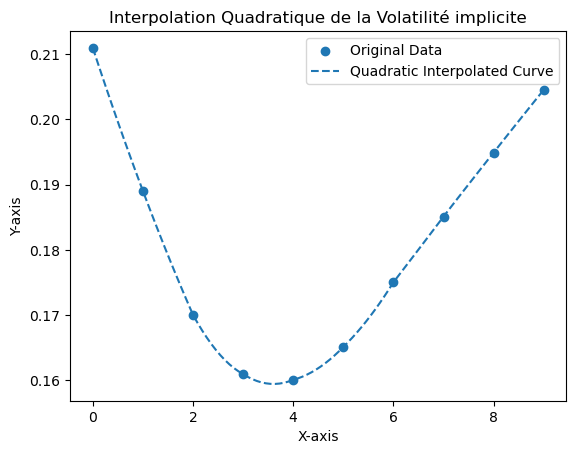

In [15]:
x_original = np.array(data.index)
y_original = np.array(data["implied_vol"])

nb_pts = 100
x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
vol_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, vol_interpolated, label='Quadratic Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Interpolation Quadratique de la Volatilité implicite')
plt.show()

Interpolation des strikes

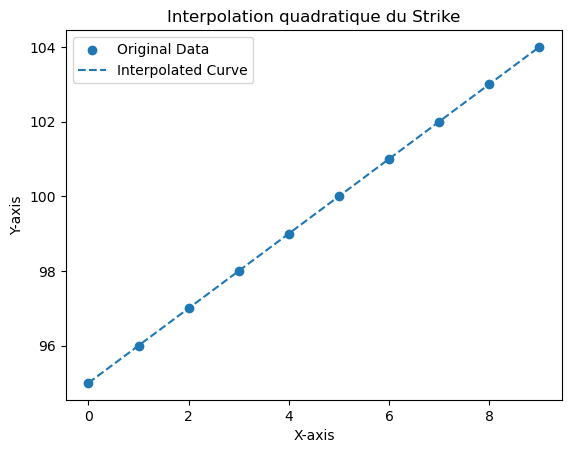

In [16]:
x_original=data.index
y_original=data["strikes"]
nb_pts=100
x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, strike_interpolated, label='Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Interpolation quadratique du Strike')
plt.show()

Calcul des prix avec Black-Scholes avec les vol et strike interpolés

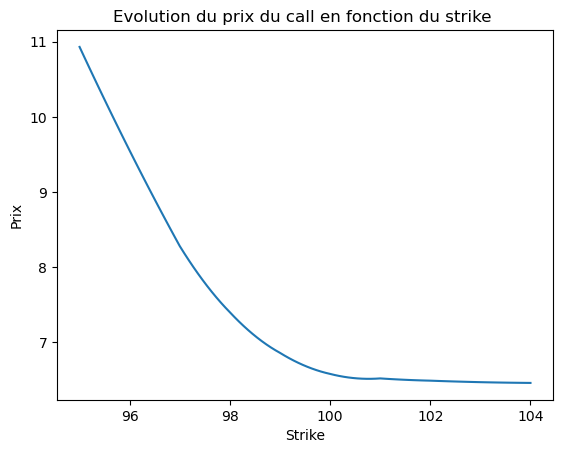

In [17]:
prices=[]

for i,j in zip(strike_interpolated,vol_interpolated):
    prices.append(black_scholes_call_price(S0,i,T,r,j))

df=pd.DataFrame([prices,strike_interpolated],index=["Price","Strike"]).T
plt.plot(np.array(df["Strike"]),np.array(df["Price"]))
plt.title("Evolution du prix du call en fonction du strike ")
plt.ylabel("Prix")
plt.xlabel("Strike")
plt.show()

In [18]:
def neutral_risk_density(strikes , r , S0 , T , implied_vols ) :
    density = np.zeros(len(strikes))
    k=df["Strike"][1]-df["Strike"][0]
    
    for i , K in enumerate (strikes) :
        C_plus_k = black_scholes_call_price (S0 , K + k , T , r , implied_vols[i] ) 
        C_minus_k = black_scholes_call_price (S0 , K - k , T , r , implied_vols[i] ) 
        C_actuel = black_scholes_call_price (S0 , K , T , r , implied_vols[i] )

        # Formule de Breeden - Litzenberger 
        density [ i ] = np.exp( r * T ) *(( C_plus_k - 2 * C_actuel + C_minus_k ) / k ** 2)

    return density

density_risque_neutre = neutral_risk_density (strike_interpolated , r , S0 , T , vol_interpolated )

In [19]:
def gaussian(x, mu, sigma, ratio):
    return ratio * np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def objective(params, args):
    mu, sigma, ratio = params
    return np.sum((gaussian(args[0], mu, sigma, ratio) - args[1])**2)

initial_guess = [98., 5., 2.]
result = nelder_mead_gpt(objective,np.array(initial_guess),df["Strike"],density_risque_neutre)

fitted_mu, fitted_sigma, fitted_ratio = result['x']

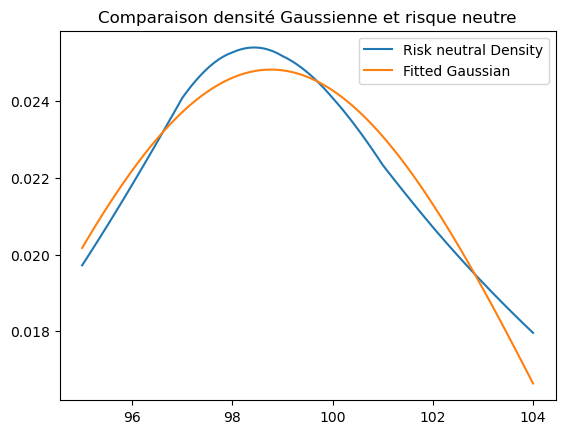

Fitted Mean: 98.76793618089212
Fitted Standard Deviation: 5.852217977950856
Fitted Amplitude (Ratio): 0.3640658899201633


In [20]:
plt.plot(df["Strike"], density_risque_neutre, label='Risk neutral Density')
plt.plot(df["Strike"], gaussian(df["Strike"], fitted_mu, fitted_sigma, fitted_ratio), label='Fitted Gaussian')
plt.title( "Comparaison densité Gaussienne et risque neutre")
plt.legend()
plt.show()

print("Fitted Mean:", fitted_mu)
print("Fitted Standard Deviation:", fitted_sigma)
print("Fitted Amplitude (Ratio):", fitted_ratio)

2/ Vérifier, en faisant des tirages dans cette loi implicite, si l’on trouve un prix de modèle proche du 
prix de marché pour toutes les options ci-dessus. 

## Garder ça + coder Algorithme de Metropolis-Hastings pour tirage dans la loi

In [21]:
# Simulation Monte Carlo pour valoriser une option
def valorisation_MC(S, K, T, r, pas, sigma,nb_simulations):
    dt=T/pas
    paths = np.zeros((nb_simulations, pas + 1))   #on créé une matrice de taille nb_simulations x pas
    paths[:, 0] = S   #on remplit la première valeur de chaque ligne avec le spot
    
    for i in range(pas):
        paths[:, i + 1] = paths[:, i] *np.exp(dt*(r - 0.5*sigma**2) + sigma*np.sqrt(dt)* ((np.random.normal(fitted_mu,fitted_sigma,size=nb_simulations)-fitted_mu)/fitted_sigma))   #tirage dans notre loi implicite
        #pour chaque pas on calcule le prix future en utilisant le spot précédent
    option_payoffs = np.maximum(paths[:, -1] - K, 0)     #on prend ensuite le max entre notre dernier spot futur calculé - strike et 0
    option_value = np.exp(-r * T) * np.mean(option_payoffs)  # on calcule la moyenne des payoffs qu'on actualise
    
    return option_value

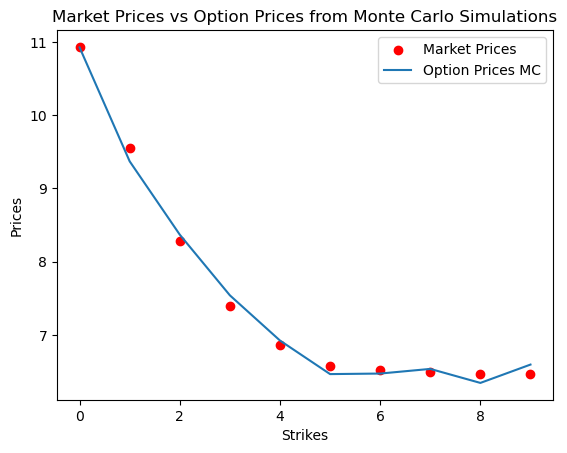

In [22]:
option_prices_mc = [valorisation_MC(S0, strike, T, r, 252, vol, 10000) for strike, vol in zip(data["strikes"], data["implied_vol"])]

fig, ax = plt.subplots()

index = np.arange(len(data["strikes"]))

rects1 = ax.scatter(index, data["prices"], label='Market Prices',color='red')
rects2 = ax.plot(index, option_prices_mc, label='Option Prices MC')

ax.set_xlabel('Strikes')
ax.set_ylabel('Prices')
ax.set_title('Market Prices vs Option Prices from Monte Carlo Simulations')
ax.legend()
plt.show()


In [23]:
for strike,vol,market_price,mc_price in zip(data["strikes"],data["implied_vol"],data["prices"],option_prices_mc):
    print(f"Option : K = {strike}, Sigma = {vol:.2f}")
    print(f"Prix par simulation de Monte Carlo = {mc_price:.2f}")
    print(f"Market Price = {market_price:.2f}\nDifference = {abs(mc_price-market_price):.2f}\n")


Option : K = 95, Sigma = 0.21
Prix par simulation de Monte Carlo = 10.92
Market Price = 10.93
Difference = 0.01

Option : K = 96, Sigma = 0.19
Prix par simulation de Monte Carlo = 9.37
Market Price = 9.55
Difference = 0.18

Option : K = 97, Sigma = 0.17
Prix par simulation de Monte Carlo = 8.37
Market Price = 8.28
Difference = 0.09

Option : K = 98, Sigma = 0.16
Prix par simulation de Monte Carlo = 7.54
Market Price = 7.40
Difference = 0.14

Option : K = 99, Sigma = 0.16
Prix par simulation de Monte Carlo = 6.92
Market Price = 6.86
Difference = 0.06

Option : K = 100, Sigma = 0.17
Prix par simulation de Monte Carlo = 6.47
Market Price = 6.58
Difference = 0.11

Option : K = 101, Sigma = 0.18
Prix par simulation de Monte Carlo = 6.47
Market Price = 6.52
Difference = 0.05

Option : K = 102, Sigma = 0.19
Prix par simulation de Monte Carlo = 6.54
Market Price = 6.49
Difference = 0.05

Option : K = 103, Sigma = 0.19
Prix par simulation de Monte Carlo = 6.34
Market Price = 6.47
Difference = 0

## II – Interpolation et volatilité locale

En plus du tableau donné précédemment, on va utiliser pour cette partie les prix d’options suivants <br>
On utilise la fonction d'interpolation quadratique, pour lisser la courbe

In [24]:
def interpolation(data,T):
    prices = []
    #interpolation of vol
    x_original = np.array(data.index)
    y_original = np.array(data["implied_vol"])
 
    nb_pts = 100
    x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
    y_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)
 
    #interpolation of strikes
    x_original=data.index
    y_original=data["strikes"]
    x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
    strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)
 
    #Calcul des prix avec la formule de black scholes en fonction des paramêtres interpolés
    for i,j in zip(strike_interpolated,y_interpolated):
        prices.append(black_scholes_call_price(S0,i,T,r,j))
   
    df=pd.DataFrame([prices,strike_interpolated,y_interpolated],index=["prices","strikes",'implied_vol']).T
    return df

In [25]:
data_12_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                'prices': [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]}
data_9_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices':[11.79 ,8.95 ,8.07 ,7.03 ,6.18 ,6.04 ,5.76 ,5.50 ,5.50 ,5.39]}
data_6_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                    'prices': [10.71 ,8.28 ,6.91 ,6.36 ,5.29 ,5.07 ,4.76 ,4.47 ,4.35 ,4.14]}
data_3_months = {'strikes': [95, 96, 97, 98, 99, 100, 101, 102, 103, 104],
                 'prices': [8.67, 7.14, 5.98, 4.93, 4.09, 3.99, 3.43, 3.01, 2.72, 2.53]}

df_12_months = pd.DataFrame(data_12_months)
df_9_months = pd.DataFrame(data_9_months)
df_6_months = pd.DataFrame(data_6_months)
df_3_months = pd.DataFrame(data_3_months)

# On utilise l'algorithme de Newton Raphson pour trouver les volatilités implicites

df_12_months["implied_vol"] = df_12_months.apply(lambda row: newton_raphson_implied_vol(row, S0, r, 1), axis=1)
df_9_months["implied_vol"] = df_9_months.apply(lambda row: newton_raphson_implied_vol(row, S0, r, 9/12), axis=1)
df_6_months["implied_vol"] = df_6_months.apply(lambda row: newton_raphson_implied_vol(row, S0, r, 6/12), axis=1)
df_3_months["implied_vol"] = df_3_months.apply(lambda row: newton_raphson_implied_vol(row, S0, r, 3/12), axis=1)


df_12_months_interp = interpolation(df_12_months,1)
df_9_months_interp = interpolation(df_9_months,0.75)
df_6_months_interp = interpolation(df_6_months,0.5)
df_3_months_interp = interpolation(df_3_months,0.25)

df_12_months['maturity'] =  [1]*10
df_9_months['maturity'] = [0.75]*10
df_6_months['maturity'] = [0.5]*10
df_3_months['maturity'] = [0.25]*10

df_12_months_interp['maturity'] =  [1]*100
df_9_months_interp['maturity'] = [0.75]*100
df_6_months_interp['maturity'] = [0.5]*100
df_3_months_interp['maturity'] = [0.25]*100


df_concatenated = pd.concat([df_12_months,df_9_months, df_6_months, df_3_months])
df_concatenated_interp = pd.concat([df_12_months_interp,df_9_months_interp, df_6_months_interp, df_3_months_interp])

df_concatenated.reset_index(drop=True,inplace=True)
df_concatenated_interp.reset_index(drop=True,inplace=True)

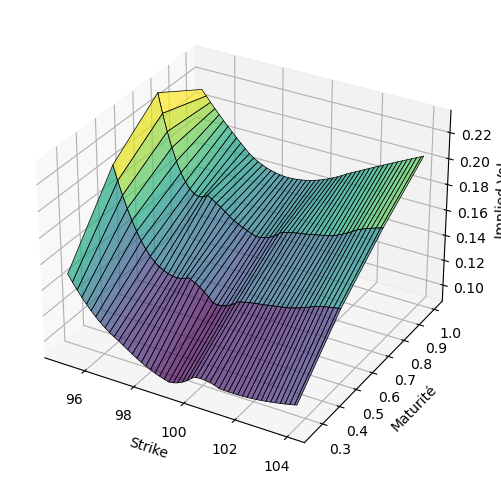

In [26]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Utilisation de plot_surface
ax.plot_surface(df_concatenated_interp['strikes'].values.reshape(4, -1),
                df_concatenated_interp['maturity'].values.reshape(4, -1),
                df_concatenated_interp['implied_vol'].values.reshape(4, -1),
                cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)

# Configurations supplémentaires
ax.set_xlabel('Strike')
ax.set_ylabel('Maturité')
ax.set_zlabel('Implied Vol')

plt.show()

Proposer un prix, le plus juste 
possible, pour une option de strike 99.50 et de maturité 8 mois (justifier la méthode retenue). 

In [27]:
def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []
    for x in x_interpolated:
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

On test l'interpolation quadratique avec une valeur que l'on connait pour estimer son erreur.<br>
Ici avec un Call K=99 T=1

In [28]:
volatility_interpolated = quadratic_interpolation([99], data["strikes"], data["implied_vol"])

print('K = 99')
print(f"The interpolated volatility = {volatility_interpolated[0]:.4f}")
print(f"Implied vol = {float(data[data['strikes']==99]['implied_vol'].values):.4f}")

K = 99
The interpolated volatility = 0.1601
Implied vol = 0.1601


In [29]:
y_interpolated = quadratic_interpolation([8/12], [0.25, 0.5, 0.75, 1], list(df_concatenated['implied_vol']))
 
print('K = 99.50 and T = 8/12')
print(f"Implied vol interpolated : {y_interpolated[0]:.4f}")

K = 99.50 and T = 8/12
Implied vol interpolated : 0.1760


We will use interp2d as a benchmark to test our functions

In [30]:
from scipy.interpolate import interp2d
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

strike_prices = list(df_concatenated_interp[df_concatenated_interp['maturity']==1]['strikes'])
maturities = [0.5, 0.75]

implied_volatilities = [
    list(df_6_months_interp['implied_vol'].values),
    list(df_9_months_interp['implied_vol'].values)  
]

interp_func = interp2d(strike_prices, maturities, implied_volatilities, kind='linear')

x_target = 99.5
z_target = 8/12

implied_volatility_8_12 = interp_func(x_target, z_target)

print(f"Implied Volatility for maturity 8/12 and strike 99.5: {implied_volatility_8_12[0]:.4f}")

Implied Volatility for maturity 8/12 and strike 99.5: 0.1371


We remark that the error is too big, and the quadratic interpolation function is not adapted to fit both interpolated strikes and maturity, so we will use the bilinear interpolation which is more adapted to interpolate 2 parameters

In [31]:
def bilinear_interpolation(x, y, points):
# Fvoir sur https ://fr.wikipedia.org/wiki/Interpolation_bilin%C3%A9aire
    points = sorted(points)
    (x1 , y1 , q11), (_x1 , y2, q12), (x2, _y1 , q21), (_x2 , _y2 , q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError("points do not form a rectangle")
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError("(x, y) not within the rectangle ")

    return (q11 * (x2 - x) * (y2 - y) +
    q21 * (x - x1) * (y2 - y) +
    q12 * (x2 - x) * (y - y1) +
    q22 * (x - x1) * (y - y1)) / ((x2 - x1) * (y2 - y1) + 0.0)

In [32]:
x_val = 99
y_val = 1
z_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_9_months_interp[df_9_months_interp['strikes'] == 98]['implied_vol'].values)),
                                            (98,1,float(df_12_months_interp[df_12_months_interp['strikes'] == 98]['implied_vol'].values)),
                                        (100,0.75,float(df_9_months_interp[df_9_months_interp['strikes'] == 100]['implied_vol'].values)),
                                        (100,1,float(df_12_months_interp[df_12_months_interp['strikes'] == 100]['implied_vol'].values))])

In [33]:
true_z_val = float(df_12_months_interp[df_12_months_interp['strikes']==99]['implied_vol'].values)
print(f'Implied vol from the dataframe : {true_z_val:.4f}')
print(f'Bilinear interpolated implied vol : {z_val:.4f}')
print(f'The error between bilinear interpolation and true value is : {abs(true_z_val - z_val):.4f}')

Implied vol from the dataframe : 0.1601
Bilinear interpolated implied vol : 0.1630
The error between bilinear interpolation and true value is : 0.0030


In [34]:
t1 = float(df_concatenated_interp[(df_concatenated_interp['strikes'] == 99) & (df_concatenated_interp['maturity'] == 1)]['prices'].values)
print(f'Market Price: {t1:.4f}')
t2 = black_scholes_call_price(100,99,1,0,z_val)
print(f'BS Call price with bilinear interpolated implied vol : {t2:.4f}')
print(f'The error is {abs(t1-t2):.4f} or {abs((t1-t2)/t1):.4f}%')

Market Price: 6.8600
BS Call price with bilinear interpolated implied vol : 6.9769
The error is 0.1169 or 0.0170%


We consider the error is acceptable so we will go with this method

In [35]:
x_val = 99.5
y_val = 8/12
z_995_val = bilinear_interpolation(x_val,y_val,[(99,0.75,float(df_9_months_interp[df_9_months_interp['strikes'] == 98]['implied_vol'].values)),
                                        (99,0.5,float(df_6_months_interp[df_6_months_interp['strikes'] == 98]['implied_vol'].values)),
                                        (100,0.75,float(df_9_months_interp[df_9_months_interp['strikes'] == 100]['implied_vol'].values)),
                                        (100,0.5,float(df_6_months_interp[df_6_months_interp['strikes'] == 100]['implied_vol'].values))
                                        ]                 
                               )

In [36]:
print(f'Implied vol from interp2d : {implied_volatility_8_12[0]:.4f}')
print(f'Bilinear interpolated implied vol : {z_995_val:.4f}')
print(f'The error between bilinear interpolation and true value is : {abs(implied_volatility_8_12[0] - z_995_val):.4f}')


prix_quad = black_scholes_call_price(100,99.5,8/12,0,y_interpolated[0])
print(f"Prix trouvé avec l'interpolation quadratique : {prix_quad:.4f}")
prix_bi = black_scholes_call_price(100,99.5,8/12,0,z_995_val)
print(f"Prix trouvé avec l'interpolation bilinéeaire : {prix_bi:.4f}")
prix_interp2d = black_scholes_call_price(100,99.5,8/12,0,implied_volatility_8_12[0])
print(f"Prix théorique avec interp2d: {prix_interp2d:.4f}")

Implied vol from interp2d : 0.1371
Bilinear interpolated implied vol : 0.1446
The error between bilinear interpolation and true value is : 0.0075
Prix trouvé avec l'interpolation quadratique : 5.9683
Prix trouvé avec l'interpolation bilinéeaire : 4.9494
Prix théorique avec interp2d: 4.7066


4/ Calibrer un modèle à volatilité locale de type SVI en suivant les étapes suivantes 

écrire l’algorithme de valorisation d’une option avec le modèle SVI, par EDP d’une part et par 
Monte Carlo d’autre part et comparer les résultats pour plusieurs jeux de paramètres 

In [37]:
param = [0.1] * 5

def svi_model(x, param):
    a,b,rho,m,sigma = param
    variance = abs(a) + abs(b) * (rho * (x - m) + np.sqrt((x - m)**2 + sigma**2))
    return np.sqrt(variance)

def forward_price_calculation(S0, r, T):
    return S0 * np.exp(r*T)

def log_moneyness_calculation(strike, forward_price):
    return np.log(strike/forward_price)

def valorisation_MC_SVI(S0, param, r, nb_simulations, pas, strike, maturity):
    dt = maturity / pas
    paths = np.zeros((nb_simulations, pas + 1))
    paths[:, 0] = S0   

    for i in range(pas):
        forward_price = forward_price_calculation(S0, r, maturity)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol = svi_model(log_moneyness, param)  
        paths[:, i + 1] = paths[:, i] * np.exp((r - 0.5 * vol**2) * dt + np.sqrt(dt * vol**2) * np.random.normal(0, 1, size=nb_simulations))

    option_payoffs = np.maximum(paths[:, -1] - strike, 0)
    option_value = np.exp(-r * maturity) * np.mean(option_payoffs)  

    return option_value

- estimez les cinq paramètres permettant de réduire au plus l’erreur moyenne ; 


In [38]:
for strike,market_price,maturity in zip(df_12_months["strikes"],df_12_months["prices"], df_12_months["maturity"]):
    option_price_mc_SVI = valorisation_MC_SVI(S0, param, r, 1000, 252, strike, maturity)
    print(f"Prix par simulation de Monte Carlo pour K = {strike}: {option_price_mc_SVI:.2f}")
    print(f"Market Price = {market_price:.2f}, Difference = {abs(option_price_mc_SVI-market_price):.2f}")

Prix par simulation de Monte Carlo pour K = 95: 15.79
Market Price = 10.93, Difference = 4.86
Prix par simulation de Monte Carlo pour K = 96: 14.75
Market Price = 9.55, Difference = 5.20
Prix par simulation de Monte Carlo pour K = 97: 14.42
Market Price = 8.28, Difference = 6.14
Prix par simulation de Monte Carlo pour K = 98: 13.87
Market Price = 7.40, Difference = 6.47
Prix par simulation de Monte Carlo pour K = 99: 12.94
Market Price = 6.86, Difference = 6.08
Prix par simulation de Monte Carlo pour K = 100: 12.19
Market Price = 6.58, Difference = 5.61
Prix par simulation de Monte Carlo pour K = 101: 11.10
Market Price = 6.52, Difference = 4.58
Prix par simulation de Monte Carlo pour K = 102: 13.38
Market Price = 6.49, Difference = 6.89
Prix par simulation de Monte Carlo pour K = 103: 12.13
Market Price = 6.47, Difference = 5.66
Prix par simulation de Monte Carlo pour K = 104: 11.13
Market Price = 6.46, Difference = 4.67


In [39]:
def cost_function_SVI(param,args):
    strikes,vols_market,maturity=args
    vols_model = [] 
    for strike in strikes : 
        forward_price = forward_price_calculation(S0, r, maturity)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vols_model.append(svi_model(log_moneyness, param))
    return np.sum((vols_model - vols_market) ** 2)

In [40]:
def check_results_svi(results,data):
    calibrated_params = results
    pas=252
    diff_totale=0
    opt = []
    for strike,market_price,maturity in zip(data["strikes"],data["prices"], data["maturity"]):
        option_price_mc_SVI = valorisation_MC_SVI(S0, calibrated_params, r, 5000, pas, strike, maturity)
        print(f"Prix par simulation de Monte Carlo pour K = {strike}: {option_price_mc_SVI:.2f}")
        print(f"Market Price = {market_price:.2f}, Difference = {abs(option_price_mc_SVI-market_price):.2f}")
        opt.append(option_price_mc_SVI)
        diff_totale+=abs(option_price_mc_SVI-market_price)
    print(diff_totale)
    fig, ax = plt.subplots()

    rects1 = ax.plot(data["strikes"], data["prices"], '-o',label='Market Prices',color='red')
    rects2 = ax.plot(data["strikes"], opt, label='Option Prices MC (SVI)')

    ax.set_xlabel('Strikes')
    ax.set_ylabel('Prices')
    ax.set_title('Market Prices vs Option Prices from Monte Carlo Simulations')
    ax.legend()
    plt.show()

param init 12 months 
[5e-3,0.6,0.05,0.12,0.1]

Prix par simulation de Monte Carlo pour K = 95: 10.47
Market Price = 10.93, Difference = 0.46
Prix par simulation de Monte Carlo pour K = 96: 9.49
Market Price = 9.55, Difference = 0.06
Prix par simulation de Monte Carlo pour K = 97: 8.87
Market Price = 8.28, Difference = 0.59
Prix par simulation de Monte Carlo pour K = 98: 7.86
Market Price = 7.40, Difference = 0.46
Prix par simulation de Monte Carlo pour K = 99: 6.85
Market Price = 6.86, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 100: 6.37
Market Price = 6.58, Difference = 0.21
Prix par simulation de Monte Carlo pour K = 101: 6.31
Market Price = 6.52, Difference = 0.21
Prix par simulation de Monte Carlo pour K = 102: 6.61
Market Price = 6.49, Difference = 0.12
Prix par simulation de Monte Carlo pour K = 103: 6.35
Market Price = 6.47, Difference = 0.12
Prix par simulation de Monte Carlo pour K = 104: 6.96
Market Price = 6.46, Difference = 0.50
2.7272666691298557


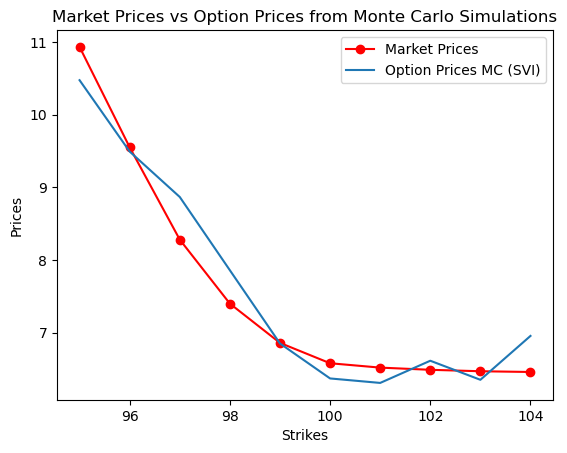

In [41]:
result_svi_12m = nelder_mead_gpt(cost_function_SVI,np.array([0.1,0.1,0.1,0.1,0.1]),df_12_months["strikes"],df_12_months["implied_vol"],1)['x']
check_results_svi(result_svi_12m,df_12_months) 

On teste la valorisation des options 12 mois et comparons à nos vraies valeurs de marché.
Pour le set de paramètres nous utilisons celui déterminé dans la suite du projet, qui minimise l'erreur moyenne.

Prix par simulation de Monte Carlo pour K = 95: 10.67
Market Price = 11.79, Difference = 1.12
Prix par simulation de Monte Carlo pour K = 96: 8.43
Market Price = 8.95, Difference = 0.52
Prix par simulation de Monte Carlo pour K = 97: 7.02
Market Price = 8.07, Difference = 1.05
Prix par simulation de Monte Carlo pour K = 98: 6.07
Market Price = 7.03, Difference = 0.96
Prix par simulation de Monte Carlo pour K = 99: 5.51
Market Price = 6.18, Difference = 0.67
Prix par simulation de Monte Carlo pour K = 100: 5.26
Market Price = 6.04, Difference = 0.78
Prix par simulation de Monte Carlo pour K = 101: 5.02
Market Price = 5.76, Difference = 0.74
Prix par simulation de Monte Carlo pour K = 102: 4.78
Market Price = 5.50, Difference = 0.72
Prix par simulation de Monte Carlo pour K = 103: 4.69
Market Price = 5.50, Difference = 0.81
Prix par simulation de Monte Carlo pour K = 104: 4.34
Market Price = 5.39, Difference = 1.05
8.43641075445796


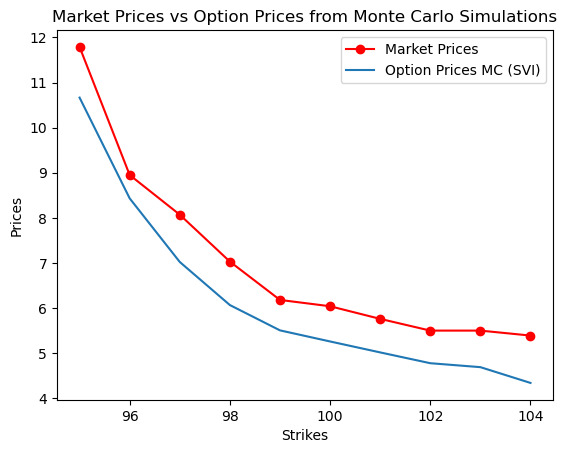

In [42]:
result_svi_9m = nelder_mead_gpt(cost_function_SVI,np.array([0.1,0.1,0.1,0.1,0.1]),df_9_months["strikes"],df_9_months["implied_vol"],0.75)['x']
check_results_svi(result_svi_9m,df_9_months) 

Notre algorithme de valorisation par Monte Carlo nous donne des prix proches

In [43]:
result_svi_6m = nelder_mead_gpt(cost_function_SVI,np.array([0.1,0.1,0.1,0.1,0.1]),df_6_months["strikes"],df_6_months["implied_vol"],0.5)['x']
result_svi_3m = nelder_mead_gpt(cost_function_SVI,np.array([0.1,0.1,0.1,0.1,0.1]),df_3_months["strikes"],df_3_months["implied_vol"],0.25)['x']

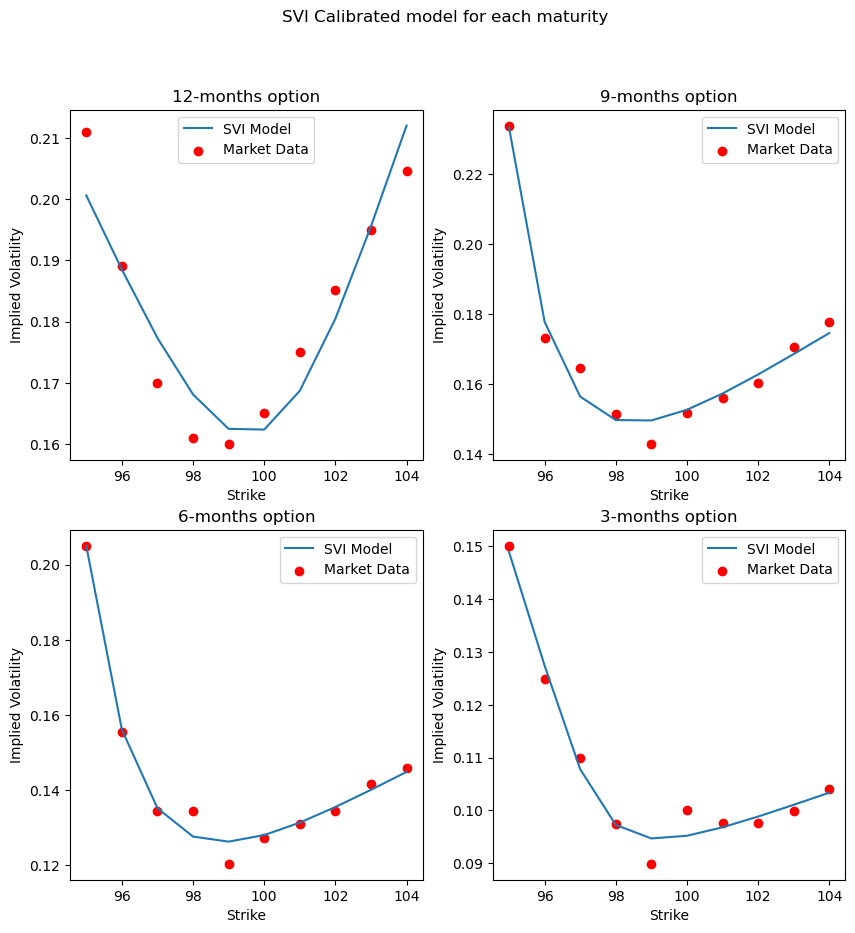

In [44]:
vols_market_12m = df_12_months["implied_vol"]
vols_market_9m = df_9_months["implied_vol"]
vols_market_6m = df_6_months["implied_vol"]
vols_market_3m = df_3_months["implied_vol"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,10))
fig.suptitle('SVI Calibrated model for each maturity')

# Visualisation de la surface de volatilité implicite
strikes_plot = np.linspace(95, 104, 10)
vols_plot_12m =[] 
for strike in strikes_plot : 
    forward_price = forward_price_calculation(S0, r, 1)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_12m.append(svi_model(log_moneyness, result_svi_12m))

ax1.plot(strikes_plot, vols_plot_12m, label='SVI Model')
ax1.scatter(strikes_plot, vols_market_12m, color='red', label='Market Data')
ax1.set_xlabel('Strike')
ax1.set_ylabel('Implied Volatility')
ax1.set_title("12-months option")
ax1.legend()

vols_plot_9m =[] 
for strike in strikes_plot : 
    forward_price = forward_price_calculation(S0, r, 0.75)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_9m.append(svi_model(log_moneyness, result_svi_9m))

ax2.plot(strikes_plot, vols_plot_9m, label='SVI Model')
ax2.scatter(strikes_plot, vols_market_9m, color='red', label='Market Data')
ax2.set_xlabel('Strike')
ax2.set_ylabel('Implied Volatility')
ax2.set_title("9-months option")
ax2.legend()

vols_plot_6m =[] 
for strike in strikes_plot : 
    forward_price = forward_price_calculation(S0, r, 0.5)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_6m.append(svi_model(log_moneyness, result_svi_6m))

ax3.plot(strikes_plot, vols_plot_6m, label='SVI Model')
ax3.scatter(strikes_plot, vols_market_6m, color='red', label='Market Data')
ax3.set_xlabel('Strike')
ax3.set_ylabel('Implied Volatility')
ax3.set_title("6-months option")
ax3.legend()

vols_plot_3m =[] 
for strike in strikes_plot : 
    forward_price = forward_price_calculation(S0, r, 0.25)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_3m.append(svi_model(log_moneyness, result_svi_3m))

ax4.plot(strikes_plot, vols_plot_3m, label='SVI Model')
ax4.scatter(strikes_plot, vols_market_3m, color='red', label='Market Data')
ax4.set_xlabel('Strike')
ax4.set_ylabel('Implied Volatility')
ax4.set_title("3-months option")
ax4.legend()

plt.show()


- on fixe tous les paramètres aux valeurs estimées ci-avant (sauf a et b) et on va calibrer les deux 
paramètres a et b pour chaque option : vous obtiendrez donc une nappe pour chacun de ces 
deux paramètres et vous introduirez une contrainte de régularisation de ces deux nappes dans 
votre problème d’optimisation. 

In [45]:
calibrated_params_svi = [result_svi_12m]+[result_svi_9m]+[result_svi_6m]+[result_svi_3m]

In [46]:
def svi_fixed(param, calibrated_params,x):
    a, b = param
    rho, m, sigma = calibrated_params[2:5]
    variance = abs(a) + abs(b) * (rho * (x - m) + np.sqrt((x - m)**2 + sigma**2))
    return np.sqrt(variance)
 
# Fonction d'erreur pour l'optimisation
def cost_function_SVI_fixed(param, args):
    calibrated_params, strike, vols_market,maturity = args
    forward_price = forward_price_calculation(S0, r, maturity)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vol = svi_fixed(param, calibrated_params,log_moneyness)
    return np.sum((vol - vols_market) ** 2)


In [47]:
a_values_12m = []
a_values_9m = []
a_values_6m = []
a_values_3m = []
b_values_12m = []
b_values_9m = []
b_values_6m = []
b_values_3m = []

In [48]:
for k,sigma in zip(strikes_plot, df_12_months['implied_vol']):
    res_12m = nelder_mead_gpt(cost_function_SVI_fixed, np.array([0.1, 0.6]), calibrated_params_svi[0], k, sigma,1)['x']
    a_12m, b_12m = res_12m
    a_values_12m.append(a_12m)
    b_values_12m.append(b_12m)
for k,sigma in zip(strikes_plot, df_9_months['implied_vol']):
    res_9m = nelder_mead_gpt(cost_function_SVI_fixed, np.array([0.1, 0.6]), calibrated_params_svi[1], k, sigma,0.75)['x']
    a_9m, b_9m = res_9m
    a_values_9m.append(a_9m)
    b_values_9m.append(b_9m)

for k,sigma in zip(strikes_plot, df_6_months['implied_vol']):
    res_6m = nelder_mead_gpt(cost_function_SVI_fixed, np.array([0.1, 0.6]), calibrated_params_svi[2], k, sigma,0.5)['x']
    a_6m, b_6m = res_6m
    a_values_6m.append(a_6m)
    b_values_6m.append(b_6m)

for k,sigma in zip(strikes_plot, df_3_months['implied_vol']):
    res_3m = nelder_mead_gpt(cost_function_SVI_fixed, np.array([0.1, 0.6]), calibrated_params_svi[3], k, sigma,0.25)['x']
    a_3m, b_3m = res_3m
    a_values_3m.append(a_3m)
    b_values_3m.append(b_3m)

In [49]:
a_values = a_values_12m+a_values_9m+a_values_6m+a_values_3m
b_values = b_values_12m+b_values_9m+b_values_6m+b_values_3m
strikes = df_concatenated["strikes"]
maturities = df_concatenated['maturity']
vol_market = df_concatenated['implied_vol']

In [50]:
def surface(strikes,maturities,values):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Utilisation de plot_surface pour créer une surface 3D
    ax.plot_surface(np.array(strikes).reshape(4,-1), 
                    np.array(maturities).reshape(4,-1),
                    np.array(values).reshape(4,-1), 
                    cmap='viridis', edgecolor='k', linewidth=0.5, alpha=0.7)

    # Configurations supplémentaires
    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturity')
    ax.set_zlabel('A values')

    # Affichage de la figure
    plt.show()

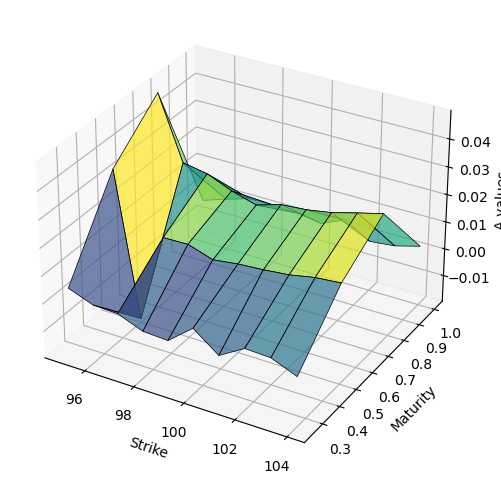

In [51]:
surface(strikes,maturities,a_values)

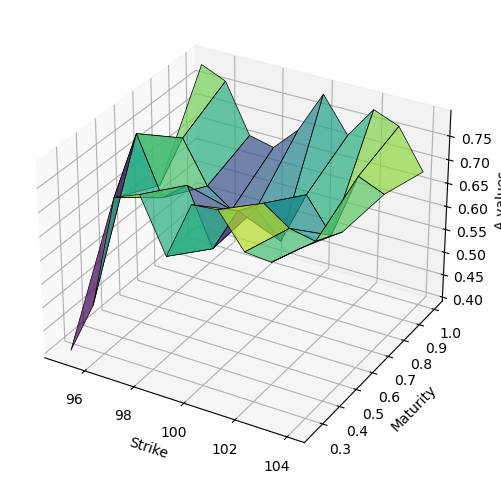

In [52]:
surface(strikes,maturities,b_values)

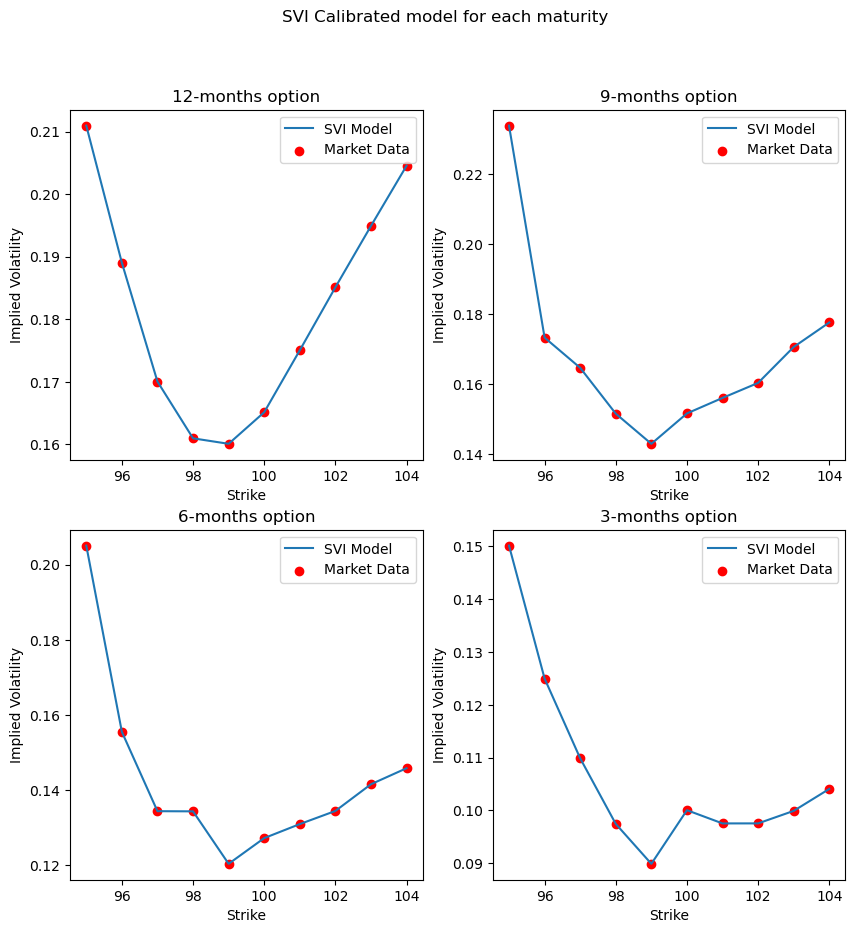

In [53]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(10,10))
fig.suptitle('SVI Calibrated model for each maturity')

# Visualisation de la surface de volatilité implicite
strikes_plot = np.linspace(95, 104, 10)
vols_plot_12m =[] 
for strike,a,b in zip(strikes_plot,a_values_12m,b_values_12m): 
    forward_price = forward_price_calculation(S0, r, 1)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_12m.append(svi_model(log_moneyness, list([a,b]) + list(result_svi_12m[2:5])))

ax1.plot(strikes_plot, vols_plot_12m, label='SVI Model')
ax1.scatter(strikes_plot, vols_market_12m, color='red', label='Market Data')
ax1.set_xlabel('Strike')
ax1.set_ylabel('Implied Volatility')
ax1.set_title("12-months option")
ax1.legend()

vols_plot_9m =[] 
for strike,a,b  in zip(strikes_plot,a_values_9m,b_values_9m) : 
    forward_price = forward_price_calculation(S0, r, 0.75)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_9m.append(svi_model(log_moneyness,list([a,b]) + list(result_svi_9m[2:5])))

ax2.plot(strikes_plot, vols_plot_9m, label='SVI Model')
ax2.scatter(strikes_plot, vols_market_9m, color='red', label='Market Data')
ax2.set_xlabel('Strike')
ax2.set_ylabel('Implied Volatility')
ax2.set_title("9-months option")
ax2.legend()

vols_plot_6m =[] 
for strike,a,b in zip(strikes_plot,a_values_6m,b_values_6m)  : 
    forward_price = forward_price_calculation(S0, r, 0.5)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_6m.append(svi_model(log_moneyness, list([a,b]) + list(result_svi_6m[2:5])))

ax3.plot(strikes_plot, vols_plot_6m, label='SVI Model')
ax3.scatter(strikes_plot, vols_market_6m, color='red', label='Market Data')
ax3.set_xlabel('Strike')
ax3.set_ylabel('Implied Volatility')
ax3.set_title("6-months option")
ax3.legend()

vols_plot_3m =[] 
for strike,a,b in zip(strikes_plot,a_values_3m,b_values_3m)  : 
    forward_price = forward_price_calculation(S0, r, 0.25)
    log_moneyness = log_moneyness_calculation(strike, forward_price)
    vols_plot_3m.append(svi_model(log_moneyness, list([a,b]) + list(result_svi_3m[2:5])))

ax4.plot(strikes_plot, vols_plot_3m, label='SVI Model')
ax4.scatter(strikes_plot, vols_market_3m, color='red', label='Market Data')
ax4.set_xlabel('Strike')
ax4.set_ylabel('Implied Volatility')
ax4.set_title("3-months option")
ax4.legend()

plt.show()


In [54]:
def cost_function_reg_b(values,args):
    
    vol_market,lam,mu = args
    values_12m,values_9m,values_6m,values_3m = np.array_split(values,4)

    vol_model = []
    for strike,a,values in zip(strikes_plot,a_values_12m,values_12m)  : 
        forward_price = forward_price_calculation(S0, r, 1)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([a,values]) + list(result_svi_12m[2:5])))
    for strike,a,values in zip(strikes_plot,a_values_9m,values_9m)  : 
        forward_price = forward_price_calculation(S0, r, 0.75)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([a,values]) + list(result_svi_9m[2:5])))
    for strike,a,values in zip(strikes_plot,a_values_6m,values_6m)  : 
        forward_price = forward_price_calculation(S0, r, 0.5)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([a,values]) + list(result_svi_6m[2:5])))
    for strike,a,values in zip(strikes_plot,a_values_3m,values_3m)  : 
        forward_price = forward_price_calculation(S0, r, 0.25)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([a,values]) + list(result_svi_3m[2:5])))

    error_vol = np.sum((vol_market-vol_model)**2)

    values_surface = pd.DataFrame()
    values_surface.index = strikes_plot
    values_surface['12'] = values_12m
    values_surface['9'] = values_9m
    values_surface['6'] = values_6m
    values_surface['3'] = values_3m

    error_strike = 0
    for i in range(1,values_surface.shape[0]):
        error_strike += (lam * np.sum(((values_surface.iloc[i]) - values_surface.iloc[i-1])**2))
    error_maturity = 0
    for m in range(3,15,3):
        error_maturity+=(mu * np.sum((values_surface[f'{m}'] - values_surface[f'{m}'])**2))
    
    print(error_vol + error_strike + error_maturity)
    
    return error_vol + error_strike + error_maturity




#### Ajouter dans le nelder mead la condition stop si < 0.001 pour b et 0.125 pour a

In [55]:
result_reg_b = nelder_mead_gpt(cost_function_reg_b,np.array(b_values),vol_market,1,1)['x']

0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.737605445005372
1.1929521528956344
1.0584017856668202
1.7029765682807352
2.0112355179260057
1.1223658096802642
1.2264221820877665
3.647319628021085
3.5195623583072084
4.042161484499757
4.991405750378082
4.851397537740084
6.686267200101102
5.995834696941944
8.110080491634111
4.18379424266031
4.060247063004771
11.134927080940065
10.120915143028325
12.557523728427997
11.70907388816821
14.132954457433842
15.217493092613209
15.813781680096733
16.83010494475546
9.484517458518118
9.239037577625657
19.97815997794077
23.531938434645298
24.296167410000415
23.166865056610956
27.031398292835835
28.21080163816517
28.681890499303332
30.341003771348756
16.63219728177902
34.214668638472645
7.330239939358337
0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.737605445005372
1.0584017856668202
1.1223658096802642
1.1929521528956344
1.2264221820877665
1.7029765

4.060247063004771
4.18379424266031
4.851397537740084
4.939830875294085
4.991405750378082
5.440767367052437
5.558708396499064
5.995834696941944
6.206043117303064
6.686267200101102
6.928538420068568
7.002710880486061
7.146520111948569
7.330239939358337
8.110080491634111
9.239037577625657
9.484517458518118
10.120915143028325
11.134927080940065
11.70907388816821
12.557523728427997
14.132954457433842
15.217493092613209
15.813781680096733
16.63219728177902
4.125821133535253
16.584469509684265
4.35032883116054
0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.737605445005372
1.0584017856668202
1.1223658096802642
1.1929521528956344
1.2264221820877665
1.7029765682807352
2.0112355179260057
3.5195623583072084
3.647319628021085
4.042161484499757
4.060247063004771
4.125821133535253
4.18379424266031
4.851397537740084
4.939830875294085
4.991405750378082
5.440767367052437
5.558708396499064
5.995834696941944
6.206043117303064
6.686267200101102
6.92853842

0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.737605445005372
1.0584017856668202
1.1223658096802642
1.1929521528956344
1.2264221820877665
1.7029765682807352
2.0112355179260057
2.3836752829867605
2.5446369573266554
2.549243545759366
2.777756328443808
3.3623004852573186
3.5195623583072084
3.647319628021085
3.676771668813458
3.946466280225673
3.9656822916135726
4.042161484499757
4.060247063004771
4.125821133535253
4.18379424266031
4.35032883116054
4.851397537740084
4.939830875294085
4.991405750378082
5.440767367052437
5.558708396499064
5.995834696941944
6.206043117303064
6.686267200101102
6.928538420068568
7.002710880486061
7.146520111948569
7.330239939358337
8.110080491634111
2.264401205125154
7.544745934614435
2.2549200084125545
0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.737605445005372
1.0584017856668202
1.1223658096802642
1.1929521528956344
1.2264221820877665
1.7029765682807352
2.0112355179260057

0.39966762644163134
0.5441718002428086
0.737605445005372
1.0584017856668202
1.1223658096802642
1.1929521528956344
1.2264221820877665
1.4755739070732925
1.513775849466819
1.7029765682807352
1.7334842276768785
1.819673111860062
1.8588631360828387
1.9383210288174
2.0112355179260057
2.2549200084125545
2.264401205125154
2.3836752829867605
2.5446369573266554
2.549243545759366
2.777756328443808
3.3623004852573186
3.5195623583072084
3.647319628021085
3.676771668813458
3.946466280225673
3.9656822916135726
4.042161484499757
4.060247063004771
4.125821133535253
4.18379424266031
4.35032883116054
4.851397537740084
4.939830875294085
4.991405750378082
5.0439860450538845
5.440767367052437
1.407302136539648
6.393602548675303
1.3739407939822421
0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.737605445005372
1.0584017856668202
1.1223658096802642
1.1929521528956344
1.2264221820877665
1.407302136539648
1.4755739070732925
1.513775849466819
1.7029765682807352

0.737605445005372
1.0584017856668202
1.0716200055400142
1.0805455978133793
1.1223658096802642
1.1487969276754324
1.1929521528956344
1.2264221820877665
1.2500563250673433
1.2677908682938608
1.2926072126829118
1.3462645867526941
1.3739407939822421
1.407302136539648
1.4755739070732925
1.513775849466819
1.7029765682807352
1.7334842276768785
1.819673111860062
1.8588631360828387
1.9383210288174
2.0112355179260057
2.2549200084125545
2.264401205125154
2.3836752829867605
2.5446369573266554
2.549243545759366
2.777756328443808
3.3623004852573186
3.5195623583072084
3.647319628021085
3.676771668813458
3.946466280225673
3.9656822916135726
4.003026571426791
1.1099494889314536
4.3461244165331365
1.0899634703685344
0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.737605445005372
1.0584017856668202
1.0716200055400142
1.0805455978133793
1.1099494889314536
1.1223658096802642
1.1487969276754324
1.1929521528956344
1.2264221820877665
1.2500563250673433
1.2677

1.7029765682807352
1.7334842276768785
1.819673111860062
1.8588631360828387
1.9383210288174
2.0112355179260057
2.2549200084125545
2.264401205125154
2.3836752829867605
2.5446369573266554
2.549243545759366
2.777756328443808
0.7320761166150948
3.539333340991068
0.7061383806656605
0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5441718002428086
0.7097377321541496
0.7320761166150948
0.737605445005372
0.9705248543815567
0.9787394624283828
1.0584017856668202
1.0716200055400142
1.0796506059277402
1.0805455978133793
1.0899634703685344
1.1099494889314536
1.1223658096802642
1.1352571894278833
1.1487969276754324
1.1929521528956344
1.2264221820877665
1.2500563250673433
1.2677908682938608
1.2926072126829118
1.3462645867526941
1.3739407939822421
1.407302136539648
1.4755739070732925
1.513775849466819
1.7029765682807352
1.7334842276768785
1.819673111860062
1.8588631360828387
1.9383210288174
2.0112355179260057
2.2549200084125545
2.264401205125154
2.3836752829867605
2.54463

1.513775849466819
1.7029765682807352
1.7334842276768785
1.7893483444414522
1.819673111860062
0.5258989029811308
1.9100743319203866
0.5259934942550226
0.2736314108481267
0.28827669288505375
0.3866628733017585
0.39966762644163134
0.5258989029811308
0.5432353808350033
0.5441718002428086
0.5925406269268814
0.633655526704906
0.6386470361863588
0.7061383806656605
0.7097377321541496
0.7135676526306202
0.7320761166150948
0.737605445005372
0.9705248543815567
0.9787394624283828
1.0584017856668202
1.0716200055400142
1.0796506059277402
1.0805455978133793
1.0899634703685344
1.1099494889314536
1.1223658096802642
1.1352571894278833
1.1487969276754324
1.1929521528956344
1.2264221820877665
1.2500563250673433
1.2677908682938608
1.2926072126829118
1.3462645867526941
1.3739407939822421
1.407302136539648
1.4585991020594218
1.4755739070732925
1.513775849466819
1.7029765682807352
1.7334842276768785
1.7893483444414522
0.5259934942550226
2.175918378530614
0.4838760472904081
0.2736314108481267
0.288276692885053

1.0716200055400142
1.0796506059277402
1.0805455978133793
1.0899634703685344
1.1099494889314536
1.1223658096802642
1.1352571894278833
1.1487969276754324
1.1929521528956344
1.2264221820877665
1.2268744133371399
1.2500563250673433
1.2677908682938608
1.290529436253466
0.3844511233865414
1.7380202631668165
0.34466400184447893
0.2736314108481267
0.28827669288505375
0.3844511233865414
0.3862840394659275
0.3866628733017585
0.3903891705079265
0.39228548455660167
0.39966762644163134
0.40113025185240114
0.4364316839085201
0.4838760472904081
0.5061414494268193
0.5258989029811308
0.5259934942550226
0.5432353808350033
0.5441718002428086
0.5925406269268814
0.633655526704906
0.6386470361863588
0.7061383806656605
0.7097377321541496
0.7135676526306202
0.7320761166150948
0.737605445005372
0.9705248543815567
0.9787394624283828
1.0584017856668202
1.0716200055400142
1.0796506059277402
1.0805455978133793
1.0899634703685344
1.1099494889314536
1.1223658096802642
1.1352571894278833
1.1487969276754324
1.19295215

1.0716200055400142
1.0796506059277402
1.0805455978133793
1.0899634703685344
0.3413889431069487
0.9969610879665409
0.2736314108481267
0.28827669288505375
0.3413889431069487
0.3413993356535984
0.34466400184447893
0.3481602971166445
0.3664961693811871
0.37355863024680497
0.37716102231349524
0.3844511233865414
0.3862840394659275
0.3866628733017585
0.3903891705079265
0.39228548455660167
0.39966762644163134
0.40113025185240114
0.4364316839085201
0.4838760472904081
0.5061414494268193
0.5258989029811308
0.5259934942550226
0.5432353808350033
0.5441718002428086
0.5925406269268814
0.633655526704906
0.6386470361863588
0.7061383806656605
0.7097377321541496
0.7135676526306202
0.7150247201234644
0.7320761166150948
0.737605445005372
0.7732369657798132
0.9561183731516852
0.9705248543815567
0.9787394624283828
1.0584017856668202
1.0716200055400142
1.0796506059277402
1.0805455978133793
0.9969610879665409
1.0365994011405908
0.2736314108481267
0.28827669288505375
0.3413889431069487
0.3413993356535984
0.3446

0.5441718002428086
0.5925406269268814
0.633655526704906
0.6386470361863588
0.7061383806656605
0.7097377321541496
0.7135676526306202
0.7150247201234644
0.7320761166150948
0.737605445005372
0.7732369657798132
0.8518488839680263
0.8565584778046992
0.2639212000017711
0.9765921649613232
0.25310591906339425
0.2639212000017711
0.2724481953859212
0.2736314108481267
0.28827669288505375
0.29519591016182223
0.29927111320425587
0.31183477899960244
0.32145858393129934
0.3413889431069487
0.3413993356535984
0.34466400184447893
0.3481602971166445
0.3664961693811871
0.37355863024680497
0.37716102231349524
0.3844511233865414
0.3862840394659275
0.3866628733017585
0.3903891705079265
0.39228548455660167
0.39966762644163134
0.40113025185240114
0.4364316839085201
0.4838760472904081
0.5061414494268193
0.5258989029811308
0.5259934942550226
0.5432353808350033
0.5441718002428086
0.5925406269268814
0.633655526704906
0.6386470361863588
0.7061383806656605
0.7097377321541496
0.7135676526306202
0.7150247201234644
0.7

0.40113025185240114
0.4364316839085201
0.4838760472904081
0.5061414494268193
0.5258989029811308
0.5259934942550226
0.5432353808350033
0.5441718002428086
0.5925406269268814
0.6064048883795453
0.6297224818719659
0.633655526704906
0.21339034647787566
0.7197309754625604
0.2019486264084744
0.18048172146563768
0.20647635472068826
0.20730355934321668
0.20954669905397108
0.21339034647787566
0.22919586491412197
0.25310591906339425
0.2533448510912786
0.2639212000017711
0.2724481953859212
0.2736314108481267
0.28827669288505375
0.29519591016182223
0.29927111320425587
0.31183477899960244
0.32145858393129934
0.3413889431069487
0.3413993356535984
0.34466400184447893
0.3481602971166445
0.3664961693811871
0.37355863024680497
0.37716102231349524
0.3844511233865414
0.3862840394659275
0.3866628733017585
0.3903891705079265
0.39228548455660167
0.39966762644163134
0.40113025185240114
0.4364316839085201
0.4838760472904081
0.5061414494268193
0.5258989029811308
0.5259934942550226
0.5432353808350033
0.5441718002

0.31183477899960244
0.32145858393129934
0.3413889431069487
0.3413993356535984
0.34466400184447893
0.3481602971166445
0.3664961693811871
0.37355863024680497
0.37716102231349524
0.3844511233865414
0.3862840394659275
0.3866628733017585
0.3903891705079265
0.39228548455660167
0.39966762644163134
0.40113025185240114
0.4164945520436231
0.4364316839085201
0.4438827886329089
0.46790455144409304
0.1560180738069711
0.5317027816512014
0.1596597095525586
0.1560180738069711
0.1702252949130876
0.18048172146563768
0.18059363920277985
0.18328060562366344
0.18810684894155963
0.2019486264084744
0.20239886027641293
0.20647635472068826
0.20730355934321668
0.20954669905397108
0.21339034647787566
0.22919586491412197
0.25310591906339425
0.2533448510912786
0.2639212000017711
0.2724481953859212
0.2736314108481267
0.28827669288505375
0.29519591016182223
0.29927111320425587
0.31183477899960244
0.32145858393129934
0.3413889431069487
0.3413993356535984
0.34466400184447893
0.3481602971166445
0.3664961693811871
0.373

0.18048172146563768
0.18059363920277985
0.18328060562366344
0.18810684894155963
0.2019486264084744
0.20239886027641293
0.20647635472068826
0.20730355934321668
0.20954669905397108
0.21339034647787566
0.22919586491412197
0.25310591906339425
0.2533448510912786
0.2639212000017711
0.2724481953859212
0.2736314108481267
0.28827669288505375
0.29519591016182223
0.29927111320425587
0.31183477899960244
0.32145858393129934
0.32686818877518536
0.3413889431069487
0.3413993356535984
0.34466400184447893
0.3481602971166445
0.3664961693811871
0.37355863024680497
0.37716102231349524
0.3844511233865414
0.12953218638038638
0.356161228136297
0.12953218638038638
0.13982954829844307
0.14064598682953544
0.14304442244631588
0.14454198627281936
0.1462705862471198
0.15231344759534268
0.1560180738069711
0.1573516802805144
0.1596597095525586
0.1702252949130876
0.18048172146563768
0.18059363920277985
0.18328060562366344
0.18810684894155963
0.2019486264084744
0.20239886027641293
0.20647635472068826
0.2073035593432166

0.18048172146563768
0.18059363920277985
0.18328060562366344
0.18810684894155963
0.2019486264084744
0.20239886027641293
0.20647635472068826
0.20730355934321668
0.20954669905397108
0.21339034647787566
0.22919586491412197
0.25310591906339425
0.2533448510912786
0.2639212000017711
0.2724481953859212
0.2736314108481267
0.2752273563458966
0.28827669288505375
0.29519591016182223
0.29927111320425587
0.31183477899960244
0.31567246395698434
0.32145858393129934
0.32686818877518536
0.254965824213133
0.3401105574734694
0.12079010779982872
0.12206256927891194
0.1262332383933574
0.12924504032200995
0.12953218638038638
0.1300533464558612
0.13858465612061902
0.13982954829844307
0.14064598682953544
0.14304442244631588
0.14454198627281936
0.1462705862471198
0.15231344759534268
0.1560180738069711
0.1573516802805144
0.1596597095525586
0.1702252949130876
0.18048172146563768
0.18059363920277985
0.18328060562366344
0.18810684894155963
0.2019486264084744
0.20239886027641293
0.20647635472068826
0.207303559343216

0.13982954829844307
0.14064598682953544
0.14304442244631588
0.14454198627281936
0.1462705862471198
0.15231344759534268
0.1560180738069711
0.1573516802805144
0.1596597095525586
0.16360509761967454
0.1702252949130876
0.18048172146563768
0.18059363920277985
0.18328060562366344
0.18502660003841445
0.18810684894155963
0.2019486264084744
0.20239886027641293
0.20647635472068826
0.20730355934321668
0.20954669905397108
0.21339034647787566
0.22919586491412197
0.2389149077927914
0.25310591906339425
0.2533448510912786
0.254965824213133
0.2599511814042537
0.2639212000017711
0.26770268669775427
0.09966071326483134
0.2764979945950945
0.09994383861635592
0.09862335460249182
0.09966071326483134
0.11078092082456338
0.11218716692250023
0.12079010779982872
0.12206256927891194
0.1262332383933574
0.12924504032200995
0.12953218638038638
0.1300533464558612
0.13858465612061902
0.13982954829844307
0.14064598682953544
0.14304442244631588
0.14454198627281936
0.1462705862471198
0.15231344759534268
0.15601807380697

0.1702252949130876
0.18048172146563768
0.18059363920277985
0.18328060562366344
0.18502660003841445
0.18810684894155963
0.2019486264084744
0.20239886027641293
0.20647635472068826
0.20730355934321668
0.20954669905397108
0.21339034647787566
0.18453095543274314
0.16253596984956786
0.08456719271850305
0.09078390079541107
0.09403607022101729
0.09429390064090434
0.09542435299658894
0.09718644743967342
0.09862335460249182
0.09966071326483134
0.09994383861635592
0.11078092082456338
0.11218716692250023
0.12079010779982872
0.12206256927891194
0.1262332383933574
0.12924504032200995
0.12953218638038638
0.1300533464558612
0.13858465612061902
0.13982954829844307
0.14064598682953544
0.14304442244631588
0.14454198627281936
0.1462705862471198
0.15231344759534268
0.1560180738069711
0.1573516802805144
0.1596597095525586
0.16360509761967454
0.1702252949130876
0.18048172146563768
0.18059363920277985
0.18328060562366344
0.18453095543274314
0.18502660003841445
0.18810684894155963
0.2019486264084744
0.20239886

0.06888159153045728
0.07319891480873122
0.07642416697744157
0.08101856846655871
0.0821438898872057
0.08300705789569628
0.08456719271850305
0.09078390079541107
0.09403607022101729
0.09429390064090434
0.09542435299658894
0.09718644743967342
0.09862335460249182
0.09966071326483134
0.09994383861635592
0.11078092082456338
0.11218716692250023
0.12079010779982872
0.12206256927891194
0.1262332383933574
0.12924504032200995
0.12953218638038638
0.1300533464558612
0.13858465612061902
0.13982954829844307
0.14064598682953544
0.14304442244631588
0.14454198627281936
0.1462705862471198
0.15231344759534268
0.15598371114950782
0.1560180738069711
0.1573516802805144
0.1596597095525586
0.16253596984956786
0.16360509761967454
0.1702252949130876
0.17956768133262102
0.18048172146563768
0.18059363920277985
0.13105471262150506
0.22772483270288438
0.07095298916231896
0.06888159153045728
0.07319891480873122
0.07642416697744157
0.08101856846655871
0.0821438898872057
0.08300705789569628
0.08456719271850305
0.0907839

0.15598371114950782
0.1560180738069711
0.06938411529796361
0.15098564652195154
0.05643320032726629
0.06291700678296744
0.06705170533395044
0.06761917625509693
0.06888159153045728
0.06938411529796361
0.07095298916231896
0.07319891480873122
0.0756449500813917
0.07642416697744157
0.08101856846655871
0.0821438898872057
0.08300705789569628
0.08456719271850305
0.09078390079541107
0.09403607022101729
0.09429390064090434
0.09542435299658894
0.09718644743967342
0.09862335460249182
0.09966071326483134
0.09994383861635592
0.11078092082456338
0.1113137092930128
0.11218716692250023
0.12079010779982872
0.12206256927891194
0.1262332383933574
0.12924504032200995
0.12953218638038638
0.1300533464558612
0.13105471262150506
0.13858465612061902
0.13982954829844307
0.14064598682953544
0.14304442244631588
0.14454198627281936
0.1462705862471198
0.15231344759534268
0.15598371114950782
0.15098564652195154
0.1977945622825459
0.06548033389918774
0.05643320032726629
0.06291700678296744
0.06705170533395044
0.067619

0.12206256927891194
0.1262332383933574
0.12924504032200995
0.12953218638038638
0.1300533464558612
0.13105471262150506
0.13807219861255718
0.13858465612061902
0.06347510064554367
0.10193887968476391
0.05643320032726629
0.06291700678296744
0.06347510064554367
0.06462188020053125
0.06548033389918774
0.06642259295725303
0.06705170533395044
0.06761917625509693
0.0687252418612341
0.06888159153045728
0.06938411529796361
0.07095298916231896
0.07319891480873122
0.0756449500813917
0.07642416697744157
0.08101856846655871
0.0821438898872057
0.08300705789569628
0.08456719271850305
0.0849989404237863
0.09078390079541107
0.09403607022101729
0.09429390064090434
0.09542435299658894
0.09718644743967342
0.09862335460249182
0.09966071326483134
0.09994383861635592
0.10958067768430331
0.11078092082456338
0.1113137092930128
0.11218716692250023
0.12079010779982872
0.12206256927891194
0.1262332383933574
0.12924504032200995
0.12953218638038638
0.1300533464558612
0.13105471262150506
0.13807219861255718
0.1019388

0.09542435299658894
0.09718644743967342
0.09862335460249182
0.09877475215595755
0.09966071326483134
0.09994383861635592
0.10037697167320037
0.10193887968476391
0.10353952814154266
0.10958067768430331
0.11078092082456338
0.1113137092930128
0.11218716692250023
0.05484893626030056
0.09352865352275835
0.05484893626030056
0.05643320032726629
0.0578235906578307
0.06097304139542177
0.06291700678296744
0.06344213971033517
0.06347510064554367
0.06462188020053125
0.06548033389918774
0.06642259295725303
0.06705170533395044
0.06761917625509693
0.0687252418612341
0.06888159153045728
0.06938411529796361
0.07095298916231896
0.07319891480873122
0.0756449500813917
0.07642416697744157
0.08101856846655871
0.0821438898872057
0.08300705789569628
0.08456719271850305
0.0849989404237863
0.09078390079541107
0.09270479878489446
0.09403607022101729
0.09429390064090434
0.09542435299658894
0.09718644743967342
0.09862335460249182
0.09877475215595755
0.09966071326483134
0.09994383861635592
0.10037697167320037
0.1019

0.08456719271850305
0.0849989404237863
0.08983768848329059
0.09078390079541107
0.09270479878489446
0.09352865352275835
0.09403607022101729
0.09429390064090434
0.09542435299658894
0.09703654149222263
0.09718644743967342
0.09862335460249182
0.04643317095685116
0.09081469309718816
0.04643317095685116
0.04773531233208124
0.047985246195040736
0.048569381422427844
0.04938045259793762
0.049658707979425835
0.05484893626030056
0.05643320032726629
0.0578235906578307
0.06097304139542177
0.06291700678296744
0.06344213971033517
0.06347510064554367
0.06462188020053125
0.06548033389918774
0.06642259295725303
0.06705170533395044
0.06761917625509693
0.0687252418612341
0.06888159153045728
0.06938411529796361
0.07095298916231896
0.07247881463945344
0.07319891480873122
0.0756449500813917
0.07642416697744157
0.08101856846655871
0.0821438898872057
0.08300705789569628
0.08456719271850305
0.0849989404237863
0.08983768848329059
0.09078390079541107
0.09270479878489446
0.09352865352275835
0.09403607022101729
0.0

0.06347510064554367
0.06462188020053125
0.06548033389918774
0.06642259295725303
0.06684553720601377
0.06705170533395044
0.06761917625509693
0.0687252418612341
0.06888159153045728
0.06938411529796361
0.07095298916231896
0.07247881463945344
0.07319891480873122
0.07508842448287581
0.0756449500813917
0.07642416697744157
0.08101856846655871
0.0821438898872057
0.08300705789569628
0.08355827934038643
0.08456719271850305
0.0849989404237863
0.08983768848329059
0.09078390079541107
0.04509737132839549
0.07395539100128053
0.04263084865857176
0.04445672690238531
0.04509737132839549
0.04643317095685116
0.04687599451270933
0.04773531233208124
0.047985246195040736
0.048569381422427844
0.04938045259793762
0.049658707979425835
0.05484893626030056
0.05643320032726629
0.0578235906578307
0.06084914052450178
0.06097304139542177
0.06291700678296744
0.06344213971033517
0.06347510064554367
0.06462188020053125
0.06548033389918774
0.06642259295725303
0.06684553720601377
0.06705170533395044
0.06761917625509693
0.

0.06684553720601377
0.06705170533395044
0.06761917625509693
0.0687252418612341
0.06874278525958527
0.06888159153045728
0.06938411529796361
0.07095298916231896
0.07247881463945344
0.07319891480873122
0.07395539100128053
0.07508842448287581
0.05091066231385748
0.09523588464386529
0.03762292675299271
0.0400805267287088
0.04237789837286648
0.04263084865857176
0.04369741945814092
0.04438779032545877
0.04445672690238531
0.04509737132839549
0.04643317095685116
0.04687599451270933
0.04773531233208124
0.047985246195040736
0.048569381422427844
0.04938045259793762
0.049658707979425835
0.05091066231385748
0.05484893626030056
0.05643320032726629
0.0578235906578307
0.06084914052450178
0.06097304139542177
0.06271754547579164
0.06291700678296744
0.06344213971033517
0.06347510064554367
0.06462188020053125
0.06491820254840254
0.06548033389918774
0.06642259295725303
0.06673272889809088
0.06684553720601377
0.06705170533395044
0.06761917625509693
0.0687252418612341
0.06874278525958527
0.06888159153045728
0

0.05484893626030056
0.05555930950301494
0.05643320032726629
0.0578235906578307
0.06084914052450178
0.06097304139542177
0.06271754547579164
0.06291700678296744
0.06344213971033517
0.06347510064554367
0.06462188020053125
0.06491820254840254
0.06548033389918774
0.06642259295725303
0.06673272889809088
0.06684553720601377
0.06705170533395044
0.06592599035342048
0.05381430100666683
0.03680083529124177
0.037339143317698324
0.03762292675299271
0.0381437477945281
0.03854669372240312
0.03908362279356332
0.0400805267287088
0.04237789837286648
0.04263084865857176
0.0427748701972238
0.04369741945814092
0.04438779032545877
0.04445672690238531
0.04509737132839549
0.04643317095685116
0.04687599451270933
0.04773531233208124
0.047985246195040736
0.048569381422427844
0.04938045259793762
0.049658707979425835
0.050235523185462275
0.05091066231385748
0.05484893626030056
0.05555930950301494
0.05643320032726629
0.0578235906578307
0.06084914052450178
0.06097304139542177
0.06271754547579164
0.06291700678296744


0.0400805267287088
0.04237789837286648
0.04263084865857176
0.0427748701972238
0.04369741945814092
0.04438779032545877
0.04445672690238531
0.044582056693865994
0.04509737132839549
0.04643317095685116
0.04687599451270933
0.047299114023604774
0.04773531233208124
0.047985246195040736
0.048569381422427844
0.04938045259793762
0.049658707979425835
0.050235523185462275
0.05091066231385748
0.05381430100666683
0.05484893626030056
0.05555930950301494
0.05643320032726629
0.057685763402959986
0.0578235906578307
0.06084914052450178
0.06097304139542177
0.06271754547579164
0.06291700678296744
0.04320984620608128
0.04741717580518784
0.03440432275228965
0.03520306529279035
0.03555427830144369
0.03622058436989084
0.03680083529124177
0.037339143317698324
0.03762292675299271
0.0381437477945281
0.03854669372240312
0.03908362279356332
0.03926421094170425
0.0400805267287088
0.04237789837286648
0.04263084865857176
0.0427748701972238
0.04320984620608128
0.04369741945814092
0.04438779032545877
0.0444567269023853

0.050235523185462275
0.05091066231385748
0.05381430100666683
0.05482060567011946
0.04394147009857661
0.056807778464542984
0.031553181962751926
0.02906220622744904
0.0312063576899463
0.031343125602723676
0.03203655993087579
0.03294476900027857
0.03440432275228965
0.03520306529279035
0.03555427830144369
0.03622058436989084
0.03680083529124177
0.037339143317698324
0.03762292675299271
0.0381437477945281
0.03854669372240312
0.03908362279356332
0.03926421094170425
0.0400805267287088
0.04237789837286648
0.04263084865857176
0.0427748701972238
0.04320984620608128
0.04369741945814092
0.04394147009857661
0.04438779032545877
0.04445672690238531
0.044582056693865994
0.04509737132839549
0.046090457386387236
0.04643317095685116
0.04687599451270933
0.047299114023604774
0.04741717580518784
0.04773531233208124
0.047985246195040736
0.048569381422427844
0.04938045259793762
0.049658707979425835
0.050235523185462275
0.05091066231385748
0.05381430100666683
0.031553181962751926
0.05855446340483951
0.030979694

0.037393158206372394
0.03762292675299271
0.0381437477945281
0.03854669372240312
0.03908362279356332
0.03926421094170425
0.0400805267287088
0.04061890575537366
0.04237789837286648
0.04263084865857176
0.0427748701972238
0.04320984620608128
0.04369741945814092
0.04394147009857661
0.04438779032545877
0.04445672690238531
0.044582056693865994
0.04509737132839549
0.046090457386387236
0.04643317095685116
0.04687599451270933
0.047299114023604774
0.028059917316523995
0.06323389227242238
0.027269376955537387
0.028059917316523995
0.02906220622744904
0.029253225276997922
0.029557794493062218
0.029851624841521752
0.03097969428956617
0.0312063576899463
0.031343125602723676
0.031553181962751926
0.03203655993087579
0.03294476900027857
0.033502286801049705
0.03366984740958953
0.03440432275228965
0.03520306529279035
0.03555427830144369
0.03622058436989084
0.03680083529124177
0.037339143317698324
0.037393158206372394
0.03762292675299271
0.0381437477945281
0.03854669372240312
0.03908362279356332
0.03926421

0.026762713056345276
0.027269376955537387
0.02735489900574674
0.02780740985946298
0.028059917316523995
0.02906220622744904
0.029253225276997922
0.02930284213931656
0.029557794493062218
0.029851624841521752
0.03097969428956617
0.0312063576899463
0.031343125602723676
0.031553181962751926
0.03203655993087579
0.03294476900027857
0.033395857583116535
0.033502286801049705
0.03366984740958953
0.03440432275228965
0.03472380969634758
0.03520306529279035
0.03555427830144369
0.03622058436989084
0.03680083529124177
0.037339143317698324
0.037393158206372394
0.03762292675299271
0.0381437477945281
0.03854669372240312
0.03908362279356332
0.03926421094170425
0.03937457171456567
0.0400805267287088
0.04061890575537366
0.04237789837286648
0.04263084865857176
0.0427748701972238
0.04320984620608128
0.02604803555178196
0.05265099034427887
0.025725895890283033
0.02561953946914492
0.02604803555178196
0.026762713056345276
0.027269376955537387
0.02735489900574674
0.02780740985946298
0.028059917316523995
0.029062

0.0381437477945281
0.03854669372240312
0.026400127931878965
0.02677509711176359
0.023728716209303658
0.02520120933762224
0.02561953946914492
0.0256812264918642
0.02571760688441904
0.025725895890283033
0.02604803555178196
0.026400127931878965
0.026616860943352295
0.026762713056345276
0.027269376955537387
0.02735489900574674
0.02780740985946298
0.028059917316523995
0.02906220622744904
0.029253225276997922
0.02930284213931656
0.029557794493062218
0.029699788661038815
0.029851624841521752
0.03097969428956617
0.0312063576899463
0.031343125602723676
0.031553181962751926
0.03203655993087579
0.03294476900027857
0.033395857583116535
0.033502286801049705
0.03366984740958953
0.03394778545500042
0.03440432275228965
0.03472380969634758
0.03520306529279035
0.03555427830144369
0.03622058436989084
0.03680083529124177
0.037339143317698324
0.037393158206372394
0.03762292675299271
0.0381437477945281
0.02677509711176359
0.029070887292964646
0.023728716209303658
0.02520120933762224
0.02561953946914492
0.02

0.02520120933762224
0.02561953946914492
0.0256812264918642
0.02571760688441904
0.025725895890283033
0.02604803555178196
0.026400127931878965
0.026616860943352295
0.026711177749921784
0.026762713056345276
0.02677509711176359
0.026844165132815956
0.027269376955537387
0.02735489900574674
0.02780740985946298
0.028059917316523995
0.02906220622744904
0.029070887292964646
0.02921233318733485
0.029253225276997922
0.02930284213931656
0.029557794493062218
0.029699788661038815
0.029851624841521752
0.03097969428956617
0.0312063576899463
0.031343125602723676
0.031553181962751926
0.03203655993087579
0.03294476900027857
0.033395857583116535
0.033502286801049705
0.03366984740958953
0.03394778545500042
0.029286071928818647
0.03469220091526732
0.02234335910426158
0.022710042207010228
0.023287918442684907
0.023728716209303658
0.023992628401155555
0.024217807055867256
0.02482073810234279
0.02520120933762224
0.02561953946914492
0.0256812264918642
0.02571760688441904
0.025725895890283033
0.02604803555178196

0.029286071928818647
0.02930284213931656
0.029557794493062218
0.029699788661038815
0.029851624841521752
0.03097969428956617
0.02230720370898565
0.018934728947284228
0.03530424347860334
0.02186675231207604
0.021867163980377857
0.022088616954278495
0.02230720370898565
0.02234335910426158
0.022408260887880754
0.022710042207010228
0.023287918442684907
0.023728716209303658
0.02381961194373035
0.023992628401155555
0.024217807055867256
0.024495921971276854
0.02482073810234279
0.02520120933762224
0.025369644463807954
0.02561953946914492
0.0256812264918642
0.02571760688441904
0.025725895890283033
0.02604803555178196
0.026400127931878965
0.026616860943352295
0.026711177749921784
0.026762713056345276
0.02677509711176359
0.026844165132815956
0.027269376955537387
0.02735489900574674
0.02780740985946298
0.028059917316523995
0.02906220622744904
0.029070887292964646
0.02921233318733485
0.029253225276997922
0.029286071928818647
0.02930284213931656
0.029557794493062218
0.029699788661038815
0.02985162484

0.019924538280037606
0.01997265125776808
0.021289301876825817
0.02186675231207604
0.021867163980377857
0.022088616954278495
0.02230720370898565
0.02234335910426158
0.022408260887880754
0.02250644885784761
0.022710042207010228
0.023287918442684907
0.023728716209303658
0.02381961194373035
0.023992628401155555
0.024217807055867256
0.024495921971276854
0.02482073810234279
0.02520120933762224
0.025369644463807954
0.02561953946914492
0.0256812264918642
0.02571760688441904
0.025725895890283033
0.02604803555178196
0.026400127931878965
0.026616860943352295
0.026711177749921784
0.026762713056345276
0.02677509711176359
0.026844165132815956
0.027269376955537387
0.02735489900574674
0.02780740985946298
0.019105492561928384
0.03514317513062431
0.018508424207467164
0.018934728947284228
0.019105492561928384
0.019535087021049374
0.01964200444407572
0.019678278665031884
0.019782015898790195
0.019799291994526402
0.019924538280037606
0.01997265125776808
0.021289301876825817
0.02186675231207604
0.0218671639

0.02381961194373035
0.023992628401155555
0.024217807055867256
0.024495921971276854
0.02482073810234279
0.02520120933762224
0.025369644463807954
0.02561953946914492
0.0256812264918642
0.02571760688441904
0.025725895890283033
0.02582677392879712
0.02604803555178196
0.018319496856403113
0.03092713420186133
0.017928594539238986
0.018319496856403113
0.018482513061430207
0.018508424207467164
0.018775958414643388
0.018845973307517007
0.018934728947284228
0.01902777179117981
0.019105492561928384
0.019535087021049374
0.01964200444407572
0.019678278665031884
0.019782015898790195
0.019799291994526402
0.019924538280037606
0.01997265125776808
0.021289301876825817
0.02151558185002423
0.02186675231207604
0.021867163980377857
0.022088616954278495
0.02230720370898565
0.02234335910426158
0.022408260887880754
0.02250644885784761
0.022710042207010228
0.023287918442684907
0.023718695363051486
0.023728716209303658
0.02381961194373035
0.023992628401155555
0.024217807055867256
0.024495921971276854
0.024820738

0.02151558185002423
0.02186675231207604
0.021867163980377857
0.022088616954278495
0.02230720370898565
0.02234335910426158
0.022408260887880754
0.02250644885784761
0.022567215563636868
0.022710042207010228
0.023287918442684907
0.023718695363051486
0.023728716209303658
0.023762702489893393
0.02381961194373035
0.023992628401155555
0.024217807055867256
0.024495921971276854
0.01751750102785503
0.02617784147582139
0.017200638081249962
0.016298107133256624
0.016424682735959876
0.0168119815604223
0.01751750102785503
0.017646822470166388
0.017928594539238986
0.018159782155015
0.018319496856403113
0.018482513061430207
0.018508424207467164
0.018775958414643388
0.018845973307517007
0.018934728947284228
0.01902777179117981
0.019105492561928384
0.019535087021049374
0.01964200444407572
0.019678278665031884
0.019782015898790195
0.019799291994526402
0.019924538280037606
0.01997265125776808
0.021289301876825817
0.02151558185002423
0.02186675231207604
0.021867163980377857
0.022088616954278495
0.022307203

0.01638304075870615
0.022864898796252114
0.01651979880822102
0.015484136551990494
0.015571417314728048
0.016298107133256624
0.01638304075870615
0.016424682735959876
0.0166747847007976
0.016681681266284044
0.0168119815604223
0.016812053825433944
0.016966288580395124
0.017200638081249962
0.01751750102785503
0.017646822470166388
0.017928594539238986
0.018159782155015
0.018319496856403113
0.018482513061430207
0.018508424207467164
0.018775958414643388
0.018845973307517007
0.018934728947284228
0.01902777179117981
0.019105492561928384
0.019535087021049374
0.01964200444407572
0.019678278665031884
0.019782015898790195
0.019799291994526402
0.019924538280037606
0.01997265125776808
0.02041895807650254
0.021289301876825817
0.02151558185002423
0.02186675231207604
0.021867163980377857
0.022088616954278495
0.02230720370898565
0.02234335910426158
0.022408260887880754
0.022470581754124717
0.01651979880822102
0.023167914000655765
0.016470362806751397
0.015484136551990494
0.015571417314728048
0.0162981071

0.018319496856403113
0.018482513061430207
0.018508424207467164
0.018775958414643388
0.018845973307517007
0.018934728947284228
0.01902777179117981
0.019105492561928384
0.019535087021049374
0.01964200444407572
0.019678278665031884
0.019782015898790195
0.019799291994526402
0.019924538280037606
0.019944014295382322
0.01997172977804563
0.01997265125776808
0.02041895807650254
0.015695996882455956
0.021755895876081344
0.015354742891489612
0.014512142723281541
0.015484136551990494
0.015571417314728048
0.015695996882455956
0.015770962136918743
0.015967569398402395
0.016183309504674136
0.016298107133256624
0.01638304075870615
0.016424682735959876
0.016470362806751397
0.01651979880822102
0.0166747847007976
0.016681681266284044
0.0168119815604223
0.016812053825433944
0.016847780709289217
0.016966288580395124
0.017200638081249962
0.01751750102785503
0.017646822470166388
0.017928594539238986
0.018159782155015
0.018319496856403113
0.018482513061430207
0.018508424207467164
0.018775958414643388
0.01884

KeyboardInterrupt: 

In [ ]:
result_reg_b

In [ ]:
def cost_function_reg_a(values,args):
    
    vol_market,lam,mu = args
    values_12m,values_9m,values_6m,values_3m = np.array_split(values,4)

    vol_model = []
    for strike,values,b in zip(strikes_plot,values_12m,b_values_12m)  : 
        forward_price = forward_price_calculation(S0, r, 1)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([values,b]) + list(result_svi_12m[2:5])))
    for strike,values,b in zip(strikes_plot,values_9m,b_values_9m)  : 
        forward_price = forward_price_calculation(S0, r, 0.75)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([values,b]) + list(result_svi_9m[2:5])))
    for strike,values,b in zip(strikes_plot,values_6m,b_values_6m)  : 
        forward_price = forward_price_calculation(S0, r, 0.5)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([values,b]) + list(result_svi_6m[2:5])))
    for strike,values,b in zip(strikes_plot,values_3m,b_values_3m)  : 
        forward_price = forward_price_calculation(S0, r, 0.25)
        log_moneyness = log_moneyness_calculation(strike, forward_price)
        vol_model.append(svi_model(log_moneyness, list([values,b]) + list(result_svi_3m[2:5])))

    error_vol = np.sum((vol_market-vol_model)**2)

    values_surface = pd.DataFrame()
    values_surface.index = strikes_plot
    values_surface['12'] = values_12m
    values_surface['9'] = values_9m
    values_surface['6'] = values_6m
    values_surface['3'] = values_3m

    error_strike = 0
    for i in range(1,values_surface.shape[0]):
        error_strike += (lam * np.sum(((values_surface.iloc[i]) - values_surface.iloc[i-1])**2))
    error_maturity = 0
    for m in range(3,15,3):
        error_maturity+=(mu * np.sum((values_surface[f'{m}'] - values_surface[f'{m}'])**2))
    
    print(error_vol + error_strike + error_maturity)
    
    return error_vol + error_strike + error_maturity


In [ ]:
result_reg_a = nelder_mead_gpt(cost_function_reg_a,np.array(a_values),vol_market,1,1)['x']

In [ ]:
surface(strikes,maturities,a_values)

In [ ]:
surface(strikes,maturities,result_reg_a)

In [ ]:
surface(strikes,maturities,b_values)

In [ ]:
surface(strikes,maturities,result_reg_b)

5/ En utilisant les nappes obtenues pour le modèle SVI (à la dernière étape), proposer encore un prix, le plus juste possible, pour une option de strike 99.50 et de maturité 8 mois (justifier la méthode retenue).

In [ ]:
df_concatenated['a_values'] = a_values
df_concatenated['b_values'] = b_values

In [ ]:
x_val = 99
y_val = 1
z_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 98)]['a_values'].values)),
                                            (98,1,float(df_concatenated[(df_concatenated['maturity'] == 1) & (df_concatenated['strikes'] == 98)]['a_values'].values)),
                                        (99,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 99)]['a_values'].values)),
                                        (99,1,float(df_concatenated[(df_concatenated['maturity'] == 1) & (df_concatenated['strikes'] == 99)]['a_values'].values))
                                        ]                 
                               )
z2_val = bilinear_interpolation(x_val,y_val,[(98,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 98)]['b_values'].values)),
                                            (98,1,float(df_concatenated[(df_concatenated['maturity'] == 1) & (df_concatenated['strikes'] == 98)]['b_values'].values)),
                                        (99,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 99)]['b_values'].values)),
                                        (99,1,float(df_concatenated[(df_concatenated['maturity'] == 1) & (df_concatenated['strikes'] == 99)]['b_values'].values))
                                        ]                 
                               )

In [ ]:
forward_price = forward_price_calculation(S0, r, 1)
log_moneyness = log_moneyness_calculation(99, forward_price)
test_imp = svi_model(log_moneyness, calibrated_params_svi[0])
price = black_scholes_call_price(100,99,1,0,test_imp)
price

In [ ]:
float(df_concatenated[(df_concatenated['maturity'] == 1) & (df_concatenated['strikes'] == 99)]['prices'].values)

In [ ]:
x_val = 99.5
y_val = 8/12
a_val = bilinear_interpolation(x_val,y_val,[(99,0.5,float(df_concatenated[(df_concatenated['maturity'] == 0.5) & (df_concatenated['strikes'] == 99)]['a_values'].values)),
                                            (99,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 99)]['a_values'].values)),
                                        (100,0.5,float(df_concatenated[(df_concatenated['maturity'] == 0.5) & (df_concatenated['strikes'] == 100)]['a_values'].values)),
                                        (100,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 100)]['a_values'].values))
                                        ]                 
                               )
b_val = bilinear_interpolation(x_val,y_val,[(99,0.5,float(df_concatenated[(df_concatenated['maturity'] == 0.5) & (df_concatenated['strikes'] == 99)]['b_values'].values)),
                                            (99,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 99)]['b_values'].values)),
                                        (100,0.5,float(df_concatenated[(df_concatenated['maturity'] == 0.5) & (df_concatenated['strikes'] == 100)]['b_values'].values)),
                                        (100,0.75,float(df_concatenated[(df_concatenated['maturity'] == 0.75) & (df_concatenated['strikes'] == 100)]['b_values'].values))
                                        ]                 
                               )

In [ ]:
def linear_interpolation(x0, y0, x1, y1, x):
    slope = (y1 - y0) / (x1 - x0)
    y = y0 + slope * (x - x0)
    return y

In [ ]:
rho_8m = linear_interpolation(6,calibrated_params_svi[2][2],9,calibrated_params_svi[1][2],8)
m_8m = linear_interpolation(6,calibrated_params_svi[2][3],9,calibrated_params_svi[1][3],8)
sigma_8m = linear_interpolation(6,calibrated_params_svi[2][4],9,calibrated_params_svi[1][4],8)

In [ ]:
forward_price = forward_price_calculation(S0, r, 1)
log_moneyness = log_moneyness_calculation(99.5, forward_price)
imp_vol_svi_8 = svi_fixed([a_val,b_val],calibrated_params_svi[3],log_moneyness)
price_svi = black_scholes_call_price(100,99.5,8/12,0,imp_vol_svi_8)
print(f"Prix trouvé avec l'interpolation bilinéaire et param pour 9 mois : {price_svi:.4f}")

forward_price_int = forward_price_calculation(S0, r, 1)
log_moneyness_int = log_moneyness_calculation(99.5, forward_price_int)
imp_vol_svi_8_int = svi_fixed([a_val,b_val],[0,0,rho_8m,m_8m,sigma_8m],log_moneyness_int)
price_svi_inter = black_scholes_call_price(100,99.5,8/12,0,imp_vol_svi_8_int)
print(f"Prix trouvé avec l'interpolation bilinéaire de a et b et autres params interpolés pour 8 mois : {price_svi_inter:.4f}")

4.7066 vrai prix

6/ écrire l’algorithme de valorisation d’une option avec le modèle PDV, par Monte Carlo (les seuls rendements considérés seront ceux simulés entre la date courante et la maturité) 

In [56]:
def K1(t,param):
    return param[3] * np.exp(-param[3] * t)

def K2(t,param):
    return param[3] * np.exp(-param[4] * t)

def R(x):
    epsilon = 1e-7  # Une petite constante
    return (x[:,1] / (x[:,0] + epsilon)) - 1
def PDV_model(param,x,t):  
    rt = R(x)
    sigma  = param[0] + param[1]*(sum(([K1(T-i/t,param)*rt for i in range(t)]))) + param[2]*(np.sqrt(sum([K2(T-i/t,param)*(rt**2) for i in range(t)])))
    #print(sigma)
    return sigma

In [ ]:
def cost_function_pdv(param,args):
    vol_maket,paths= args
    vol_model = []
    for i in range(1,len(paths))
        vol_model.append(PDV_model(param,paths[0:,i-1:i+1],len(paths)))
    
    return np.sum((pdv_vol - vol_model)**2)
    

In [57]:
def valorisation_MC_PDV(S, param,r, nb_simulations, pas, strike, T):
    dt=T/pas

    paths = np.zeros((nb_simulations, pas + 1))
    paths[:, 0:2] = S 
        
    for i in range(1,pas):
        vol = PDV_model(param,paths[0:, i-1:i+1],pas)  #A chaque pas on calcule notre volatilité avec le modèle PDV
        paths[0:, i + 1] = paths[0:, i] * np.exp((r-0.5 * vol **2) * dt + vol * np.sqrt(dt) * np.random.normal(0,1,size=nb_simulations))
    option_payoffs = np.maximum(paths[0:, -1] - strike, 0)
    option_value = np.exp(-r * T) * np.mean(option_payoffs)  #payoff actualisé
    return option_value,paths

In [58]:
def error_MC_PDV(param, args):
    paths,maturity,strikes,market_prices = args
    option_values = []
    for strike in strikes:
        for i in range(1,len(paths)):
            vol = PDV_model(param,paths[0:, i-1:i+1],pas)  #A chaque pas on calcule notre volatilité avec le modèle PDV
        option_payoffs = np.maximum(paths[0:, -1] - strike, 0)
        option_values.append(np.exp(-r * maturity) * np.mean(option_payoffs))  #payoff actualisé
    print(np.sum((option_values - market_prices)**2))
    return np.sum((option_values - market_prices)**2)

In [65]:
paths_PDV[:,1:2]

TypeError: list indices must be integers or slices, not tuple

On valorise nos options 1 an et les comparons à notre prix de marché

In [59]:
# Parameters for the PDV model
lambda_1 = 0.5 # Lambda 1 ne peut pas etre negatif
lambda_2 = 0.3
beta_0 = 0.1 
beta_1 = 0.2  
beta_2 = 0.3   

In [60]:
param = [beta_0, beta_1, beta_2, lambda_1, lambda_2]
#param = [0.17939141,0.22817693,-0.21715067,0.1,-0.28060548]
nb_simulations = 10000
maturity=1
pas=100
paths_PDV = []
total_error = 0
for strike,price in zip(data["strikes"],data["prices"]):
    option_price,paths = valorisation_MC_PDV(S0, param,r, nb_simulations, pas, strike, maturity)
    paths_PDV.append(paths)
    print(f"Prix par simulation de Monte Carlo pour K = {strike} : {option_price:.2f}")
    print(f"Market Price = {price:.2f}, Difference = {abs(option_price-price):.2f}")
    total_error+=abs(option_price-price)
print(f'total error :{total_error:.2f}')

Prix par simulation de Monte Carlo pour K = 95 : 9.62
Market Price = 10.93, Difference = 1.31
Prix par simulation de Monte Carlo pour K = 96 : 9.06
Market Price = 9.55, Difference = 0.49
Prix par simulation de Monte Carlo pour K = 97 : 8.37
Market Price = 8.28, Difference = 0.09
Prix par simulation de Monte Carlo pour K = 98 : 8.15
Market Price = 7.40, Difference = 0.75
Prix par simulation de Monte Carlo pour K = 99 : 7.84
Market Price = 6.86, Difference = 0.98
Prix par simulation de Monte Carlo pour K = 100 : 7.09
Market Price = 6.58, Difference = 0.51
Prix par simulation de Monte Carlo pour K = 101 : 6.99
Market Price = 6.52, Difference = 0.47
Prix par simulation de Monte Carlo pour K = 102 : 6.50
Market Price = 6.49, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 103 : 6.06
Market Price = 6.47, Difference = 0.41
Prix par simulation de Monte Carlo pour K = 104 : 5.80
Market Price = 6.46, Difference = 0.66
total error :5.67


estimez les cinq paramètres permettant de réduire au plus l’erreur moyenne ;

Afin d'estimer les cinq paramètres nous utilisons les path simulés avec monte carlo


In [62]:
initial_params = [0.17939141,0.22817693,-0.21715067,0.1,-0.28060548]
result_PDV = nelder_mead_gpt(error_MC_PDV,np.array(initial_params),paths_PDV,1,data_12_months['strikes'],data_12_months['prices'])

TypeError: list indices must be integers or slices, not tuple